# CAPTURA DE DADOS DE IMAGENS DO SATÉLITE SENTINEL 2
## Valores de Reflectância de Pixels e Colunas Adicionais

In [1]:
# Os dados de entrada devem estar padronizados (colunas necessárias):
#'Sample_Date', 'Time_Sample', 'Station_Sample', 'Parameter',
# 'Value','Unit', 'Depth', 'Depth_Unit', 'Local_Name',
#'Location_Type', 'Lat', 'Lon', 'Country',
#'Organization_Data', 'Hemisphere', 'Season', 'Source_Domain'

# O formato do arquivo com dados de entrada deve estar no formato .csv, .xls ou xlsx
# Exemplo: https://drive.google.com/file/d/1nNKA2ZzPilK8wZ2pfeKvj5dxOkJNFQw6/view?usp=share_link

In [2]:
# Ambiente de Execução

print('----------------------------------------------------------------------------------')
print('SELECIONE O AMBIENTE DE EXECUÇÃO')
print('----------------------------------------------------------------------------------')
print('Digite 1 GOOGLE COLAB')
print('Digita 0 para AMBIENTE LOCAL')
google_colab = int(input('Informe o Ambiente de Execução do Código: '))

print('----------------------------------------------------------------------------------')


if google_colab != 1:
    google_colab = 0

if google_colab == 1:
    print('Executar Código no Google Colab')
else:
    print('Executar Código em Ambiente Local')

----------------------------------------------------------------------------------
SELECIONE O AMBIENTE DE EXECUÇÃO
----------------------------------------------------------------------------------
Digite 1 GOOGLE COLAB
Digita 0 para AMBIENTE LOCAL
Informe o Ambiente de Execução do Código: 0
----------------------------------------------------------------------------------
Executar Código em Ambiente Local


In [3]:
# Instalando bibliotecas de manipulação de dados vetoriais
#!pip install pyshp --quiet
#!pip install geopandas --quiet

if google_colab == 1:
    !pip install pyshp --quiet
    !pip install geopandas --quiet

In [4]:
# Importando bibliotecas
import pandas as pd
import ee
import os
import numpy as np
import geopandas as gpd
import shapefile
import datetime as dt
import matplotlib.pyplot as plt
from shapely.geometry import Point
import sys
import seaborn as srn

#from google.colab
import tkinter as tk
from tkinter import filedialog

import io
import time

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 500)

from IPython.display import clear_output
from time import sleep

In [5]:
# Nome do conjunto de dados: Informe o nome do Dataset
conjunto_dados = '_Ceara_Dataset_'

In [6]:
# Autenticando no Google Earth Engine
ee.Authenticate()
ee.Initialize()

Enter verification code: 4/1AVG7fiSvScrurvK9Tbzzk2KLwUjoiWtugdse00f6NhSZF_26ZWDnoYAkTQM

Successfully saved authorization token.


In [7]:
# Abre arquivo com base de dados: Seleção
if google_colab == 0:
    root = tk.Tk()
    #root.withdraw()
    arquivo = filedialog.askopenfilename()
    root.update()
    root.destroy()
    #print(arquivo)

    # Pegando o nome do arquivo
    nome_arquivo = next(iter(arquivo))
    nome_arquivo = str(arquivo)
    print(arquivo)

else:
    # Carregando o arquivo direto do computador local para o Google Colab
    from google.colab import files
    arquivo = files.upload()

    # Pegando o nome do arquivo
    nome_arquivo = next(iter(arquivo))
    nome_arquivo = str(nome_arquivo)
    print(arquivo)

/home/peixe/simoa/0_Fase_7/Captura_Dados_GEE/Clorofila/Ceara_Novo/Ceara_Variavel_Clorofila_Dados_e_Estacoes.csv


In [8]:
# Convertendo o arquivo para o formato .csv (se necessário) e fazendo leitura
if google_colab == 0:
  if nome_arquivo.split('.')[1] == 'xlsx' or nome_arquivo.split('.')[1] == 'xls':
    dados = pd.read_excel(nome_arquivo)
    dados.to_csv(str(nome_arquivo.split('.')[0] + '.csv'))
    print('Arquivo carregado com sucesso!')
  elif nome_arquivo.split('.')[1] == 'csv':
    dados = pd.read_csv(nome_arquivo)
    print('Arquivo carregado com sucesso!')
  else:
    print('Formato de arquivo inválido! Utilize arquivo nos formatos .xlsx, .xls ou .csv')


# Convertendo o arquivo para o formato .csv (se necessário) e fazendo leitura
if google_colab == 1:
    if nome_arquivo.split('.')[1] == 'xlsx' or nome_arquivo.split('.')[1] == 'xls':
      dados = pd.read_excel(io.BytesIO(arquivo[nome_arquivo]))
      dados.to_csv(str(nome_arquivo.split('.')[0] + '.csv'))
    elif nome_arquivo.split('.')[1] == 'csv':
      dados = pd.read_csv(nome_arquivo)
    else:
      print('Formato de arquivo inválido! Utilize arquivo nos formatos .xlsx, .xls ou .csv')

Arquivo carregado com sucesso!


In [9]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1999 entries, 0 to 1998
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Sample_Date        1999 non-null   object 
 1   Time_Sample        1999 non-null   object 
 2   Station_Sample     1999 non-null   object 
 3   Parameter          1999 non-null   object 
 4   Value              1999 non-null   float64
 5   Unit               1999 non-null   object 
 6   Depth              1999 non-null   float64
 7   Depth_Unit         1999 non-null   object 
 8   Local_Name         1999 non-null   object 
 9   Location_Type      1999 non-null   object 
 10  Lat                1999 non-null   float64
 11  Lon                1999 non-null   float64
 12  Country            1999 non-null   object 
 13  Organization_Data  1999 non-null   object 
 14  Hemisphere         1999 non-null   object 
 15  Season             1999 non-null   object 
 16  Source_Domain      1999 

In [10]:
dados.columns

Index(['Sample_Date', 'Time_Sample', 'Station_Sample', 'Parameter', 'Value',
       'Unit', 'Depth', 'Depth_Unit', 'Local_Name', 'Location_Type', 'Lat',
       'Lon', 'Country', 'Organization_Data', 'Hemisphere', 'Season',
       'Source_Domain'],
      dtype='object')

In [11]:
dados.shape

(1999, 17)

In [12]:
# Ordenando por Data Mais Recente para Encontrar Dados (normalmente 2017 e 2018 não encontra muitos dados)
dados.sort_values(by=['Sample_Date'], ascending=False, inplace = True)
dados.reset_index(inplace=True)
del(dados['index'])
dados.head()

,Sample_Date,Time_Sample,Station_Sample,Parameter,Value,Unit,Depth,Depth_Unit,Local_Name,Location_Type,Lat,Lon,Country,Organization_Data,Hemisphere,Season,Source_Domain
0,2021-08-03,00:00:00,Unknow,Chlorophyll,33.46,ug/l,0.0,m,SANTO ANTÔNIO DE ARACATIAÇU,Reservoir,-3.883886,-40.012190,Brazil,UF_CE,South,Winter,Ceara
1,2021-06-23,00:00:00,Unknow,Chlorophyll,41.27,ug/l,0.0,m,BATENTE,Reservoir,-4.650259,-38.491527,Brazil,UF_CE,South,Winter,Ceara
2,2021-06-23,00:00:00,Unknow,Chlorophyll,14.05,ug/l,0.0,m,MACACOS,Reservoir,-4.801554,-38.709028,Brazil,UF_CE,South,Winter,Ceara
3,2021-06-17,00:00:00,Unknow,Chlorophyll,177.53,ug/l,0.0,m,MARANGUAPINHO,Reservoir,-3.884239,-38.651033,Brazil,UF_CE,South,Autumn,Ceara
4,2021-06-16,00:00:00,Unknow,Chlorophyll,43.57,ug/l,0.0,m,CASTRO,Reservoir,-4.566786,-38.931888,Brazil,UF_CE,South,Autumn,Ceara


In [13]:
dados.tail()

,Sample_Date,Time_Sample,Station_Sample,Parameter,Value,Unit,Depth,Depth_Unit,Local_Name,Location_Type,Lat,Lon,Country,Organization_Data,Hemisphere,Season,Source_Domain
1994,2017-04-01,00:00:00,Unknow,Chlorophyll,21.49,ug/l,0.0,m,SÃO VICENTE,Reservoir,-3.396011,-40.263856,Brazil,UF_CE,South,Autumn,Ceara
1995,2017-04-01,00:00:00,Unknow,Chlorophyll,1.32,ug/l,0.0,m,AYRES DE SOUSA,Reservoir,-3.780333,-40.499500,Brazil,UF_CE,South,Autumn,Ceara
1996,2017-04-01,00:00:00,Unknow,Chlorophyll,21.09,ug/l,0.0,m,SOBRAL,Reservoir,-3.656744,-40.366402,Brazil,UF_CE,South,Autumn,Ceara
1997,2017-04-01,00:00:00,Unknow,Chlorophyll,72.69,ug/l,0.0,m,ARARAS,Reservoir,-4.212834,-40.445415,Brazil,UF_CE,South,Autumn,Ceara
1998,2017-04-01,00:00:00,Unknow,Chlorophyll,7.99,ug/l,0.0,m,TAQUARA,Reservoir,-3.898429,-40.614304,Brazil,UF_CE,South,Autumn,Ceara


In [14]:
# Alterando Datas para String (Padrão de entrada para leitura pelo Google Earth Engine, GEE), apenas se necessário
for col in dados.columns:
  if dados[col].dtype == '<M8[ns]':
    print(f'Coluna de data: {dados[col]} {dados[col].dtype}')
    dados[col] = dados[col].apply(lambda x: x.strftime('%Y-%m-%d'))

In [15]:
# Verificando a conversão
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1999 entries, 0 to 1998
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Sample_Date        1999 non-null   object 
 1   Time_Sample        1999 non-null   object 
 2   Station_Sample     1999 non-null   object 
 3   Parameter          1999 non-null   object 
 4   Value              1999 non-null   float64
 5   Unit               1999 non-null   object 
 6   Depth              1999 non-null   float64
 7   Depth_Unit         1999 non-null   object 
 8   Local_Name         1999 non-null   object 
 9   Location_Type      1999 non-null   object 
 10  Lat                1999 non-null   float64
 11  Lon                1999 non-null   float64
 12  Country            1999 non-null   object 
 13  Organization_Data  1999 non-null   object 
 14  Hemisphere         1999 non-null   object 
 15  Season             1999 non-null   object 
 16  Source_Domain      1999 

# Buffer da Resolução Espacial

In [16]:
try:
  buffer = int(input('Digite a resolução espacial para extração dos dados (m): '))
except:
    buffer = 20

buffer

Digite a resolução espacial para extração dos dados (m): 20


20

# Intervalo de Dias entre a Passagem do Satélite e a Coleta da Amostra de Campo

In [17]:
intervalo_dias = int(input('Digite o intervalo de dias entre a data de obtenção dos dados e data de passagem do satélite: '))

# Modo para contornar problema de diferença de Dias igual a Zero
if intervalo_dias == 0:
    intervalo_dias = 2
    intervalo_zero = 'S'
    print('Diferença de dias igual a: 0')
else:
    intervalo_zero = 'N'
    print(f'Diferença de dias igual a: {intervalo_dias}')

Digite o intervalo de dias entre a data de obtenção dos dados e data de passagem do satélite: 7
Diferença de dias igual a: 7


# Variável de Interesse

In [18]:
print(dados['Parameter'].unique())
print(len(dados['Parameter'].unique()))
quant_variaveis = str(len(dados['Parameter'].unique())) + '_Variaveis'
print(quant_variaveis)

['Chlorophyll']
1
1_Variaveis


In [19]:
print('Selecione a variável de interesse: ')
opcoes = ["Turbidez", "Clorofila", "Secchi", "pH", "Oxigenio","Redox", "Solidos Suspensos", "Condutividade", "CDOM", quant_variaveis]

for i in range(len(opcoes)):
    print(str(i+1) + ":", opcoes[i])

print('------------------------')

# Loop para verificação da opção selecionada
inp = int(input("Digite o número correspondente à variável: "))
if inp in range(1,11):
    inp = opcoes[inp-1]
    print('Variável selecionada: ', inp)
else:
    print("Entrada inválida!")

variavel_interesse = str(inp)

Selecione a variável de interesse: 
1: Turbidez
2: Clorofila
3: Secchi
4: pH
5: Oxigenio
6: Redox
7: Solidos Suspensos
8: Condutividade
9: CDOM
10: 1_Variaveis
------------------------
Digite o número correspondente à variável: 2
Variável selecionada:  Clorofila


In [20]:
# Selecionar Pequena Amostragem para Testes

In [21]:
# Pegando apenas 100 dados
copia = dados.copy() # guardando pra voltar aqui, se preciso
#dados = copia.iloc[0:100,:]
#dados = copia.iloc[0:50,:]
#dados = copia.iloc[0:3,:]
dados.shape

(1999, 17)

In [22]:
dados.head()

,Sample_Date,Time_Sample,Station_Sample,Parameter,Value,Unit,Depth,Depth_Unit,Local_Name,Location_Type,Lat,Lon,Country,Organization_Data,Hemisphere,Season,Source_Domain
0,2021-08-03,00:00:00,Unknow,Chlorophyll,33.46,ug/l,0.0,m,SANTO ANTÔNIO DE ARACATIAÇU,Reservoir,-3.883886,-40.012190,Brazil,UF_CE,South,Winter,Ceara
1,2021-06-23,00:00:00,Unknow,Chlorophyll,41.27,ug/l,0.0,m,BATENTE,Reservoir,-4.650259,-38.491527,Brazil,UF_CE,South,Winter,Ceara
2,2021-06-23,00:00:00,Unknow,Chlorophyll,14.05,ug/l,0.0,m,MACACOS,Reservoir,-4.801554,-38.709028,Brazil,UF_CE,South,Winter,Ceara
3,2021-06-17,00:00:00,Unknow,Chlorophyll,177.53,ug/l,0.0,m,MARANGUAPINHO,Reservoir,-3.884239,-38.651033,Brazil,UF_CE,South,Autumn,Ceara
4,2021-06-16,00:00:00,Unknow,Chlorophyll,43.57,ug/l,0.0,m,CASTRO,Reservoir,-4.566786,-38.931888,Brazil,UF_CE,South,Autumn,Ceara


# Captura de Valores de Pixels

In [23]:
# Definição do nome do arquivo
nome_arquivo_shape = str(variavel_interesse + '.csv')
nome_arquivo_shape

'Clorofila.csv'

In [24]:
def saveProperties(w1, Ist_p_poi, i, imagedate, img_properties):
    w1.record(# Dados da Tabela Base
                  i[1]['Sample_Date'],
                  i[1]['Time_Sample'],
                  i[1]['Station_Sample'],
                  i[1]['Parameter'],
                  i[1]['Value'],
                  i[1]['Unit'],
                  i[1]['Depth'],
                  i[1]['Depth_Unit'],
                  i[1]['Local_Name'],
                  i[1]['Location_Type'],
                  i[1]["Lat"],
                  i[1]["Lon"],
                  i[1]['Country'],
                  i[1]['Organization_Data'],
                  i[1]['Hemisphere'],
                  i[1]['Season'],
                  i[1]['Source_Domain'],

                  # Hora e Dia da Imagem
                  imagedate,
                  imagehour,

                  # andas - 1 a 12
                  Ist_p_poi[1][4],
                  Ist_p_poi[1][5],
                  Ist_p_poi[1][6],
                  Ist_p_poi[1][7],
                  Ist_p_poi[1][8],
                  Ist_p_poi[1][9],
                  Ist_p_poi[1][10],
                  Ist_p_poi[1][11],
                  Ist_p_poi[1][12],
                  Ist_p_poi[1][13],
                  Ist_p_poi[1][14],
                  Ist_p_poi[1][15],

                  # MSK_CLDPRB
                  MSK_CLDPRB,
                  #Ist_p_poi[1][22],

                  # MSK_SNOW
                  MSK_SNWPRB,
                  #Ist_p_poi[1][23],

                  # QA60
                  Ist_p_poi[1][26],

                  img_properties.get('MEAN_SOLAR_AZIMUTH_ANGLE'),
                  img_properties.get('MEAN_INCIDENCE_AZIMUTH_ANGLE_B1'),
                  img_properties.get('MEAN_INCIDENCE_AZIMUTH_ANGLE_B2'),
                  img_properties.get('MEAN_INCIDENCE_AZIMUTH_ANGLE_B3'),
                  img_properties.get('MEAN_INCIDENCE_AZIMUTH_ANGLE_B4'),
                  img_properties.get('MEAN_INCIDENCE_AZIMUTH_ANGLE_B5'),
                  img_properties.get('MEAN_INCIDENCE_AZIMUTH_ANGLE_B6'),
                  img_properties.get('MEAN_INCIDENCE_AZIMUTH_ANGLE_B7'),
                  img_properties.get('MEAN_INCIDENCE_AZIMUTH_ANGLE_B8'),
                  img_properties.get('MEAN_INCIDENCE_AZIMUTH_ANGLE_B8A'),
                  img_properties.get('MEAN_INCIDENCE_AZIMUTH_ANGLE_B9'),
                  img_properties.get('MEAN_INCIDENCE_AZIMUTH_ANGLE_B10'),
                  img_properties.get('MEAN_INCIDENCE_AZIMUTH_ANGLE_B11'),
                  img_properties.get('MEAN_INCIDENCE_AZIMUTH_ANGLE_B12'),

                  img_properties.get('MEAN_SOLAR_ZENITH_ANGLE'),
                  img_properties.get('MEAN_INCIDENCE_ZENITH_ANGLE_B1'),
                  img_properties.get('MEAN_INCIDENCE_ZENITH_ANGLE_B2'),
                  img_properties.get('MEAN_INCIDENCE_ZENITH_ANGLE_B3'),
                  img_properties.get('MEAN_INCIDENCE_ZENITH_ANGLE_B4'),
                  img_properties.get('MEAN_INCIDENCE_ZENITH_ANGLE_B5'),
                  img_properties.get('MEAN_INCIDENCE_ZENITH_ANGLE_B6'),
                  img_properties.get('MEAN_INCIDENCE_ZENITH_ANGLE_B7'),
                  img_properties.get('MEAN_INCIDENCE_ZENITH_ANGLE_B8'),
                  img_properties.get('MEAN_INCIDENCE_ZENITH_ANGLE_B8A'),
                  img_properties.get('MEAN_INCIDENCE_ZENITH_ANGLE_B9'),
                  img_properties.get('MEAN_INCIDENCE_ZENITH_ANGLE_B10'),
                  img_properties.get('MEAN_INCIDENCE_ZENITH_ANGLE_B11'),
                  img_properties.get('MEAN_INCIDENCE_ZENITH_ANGLE_B12'),

                  img_properties.get('SOLAR_IRRADIANCE_B1'),
                  img_properties.get('SOLAR_IRRADIANCE_B2'),
                  img_properties.get('SOLAR_IRRADIANCE_B3'),
                  img_properties.get('SOLAR_IRRADIANCE_B4'),
                  img_properties.get('SOLAR_IRRADIANCE_B5'),
                  img_properties.get('SOLAR_IRRADIANCE_B6'),
                  img_properties.get('SOLAR_IRRADIANCE_B7'),
                  img_properties.get('SOLAR_IRRADIANCE_B8'),
                  img_properties.get('SOLAR_IRRADIANCE_B8A'),
                  img_properties.get('SOLAR_IRRADIANCE_B9'),
                  img_properties.get('SOLAR_IRRADIANCE_B10'),
                  img_properties.get('SOLAR_IRRADIANCE_B11'),
                  img_properties.get('SOLAR_IRRADIANCE_B12'),

                  img_properties.get('SPACECRAFT_NAME'),
                  img_properties.get('SENSING_ORBIT_NUMBER'),
                  img_properties.get('GRANULE_ID'),
                  img_properties.get('SENSOR_QUALITY'),
                  img_properties.get('DEGRADED_MSI_DATA_PERCENTAGE'),
                  img_properties.get('REFLECTANCE_CONVERSION_CORRECTION'),
                  img_properties.get('CLOUDY_PIXEL_PERCENTAGE'),
                  img_properties.get('CLOUD_COVERAGE_ASSESSMENT'),
                  img_properties.get('THIN_CIRRUS_PERCENTAGE'),
                  img_properties.get('MEDIUM_PROBA_CLOUDS_PERCENTAGE'),
                  img_properties.get('HIGH_PROBA_CLOUDS_PERCENTAGE'),
                  img_properties.get('DARK_FEATURES_PERCENTAGE'),
                  img_properties.get('VEGETATION_PERCENTAGE'),
                  img_properties.get('SNOW_ICE_PERCENTAGE'),
                  img_properties.get('WATER_PERCENTAGE'),

                  # Scene Classification
                  Ist_p_poi[1][18])
    return ""

In [25]:
# Verificar tempo
j = 0
tempo_inicial = time.time() # em segundos

myfile = nome_arquivo_shape # "6_variaveis_Canada.csv"

w1 = shapefile.Writer(myfile.replace('.csv','.shp'),shapeType=1)

# Campos da Tabela Base
w1.field('Sample_Date', 'C')
w1.field('Time_Sample','C'),
w1.field('Station_Sample', 'C')
w1.field('Parameter', 'C')
w1.field('Value', 'F', decimal = 6),
w1.field('Unit', 'C')
w1.field('Depth', 'F', decimal = 4)
w1.field('Depth_Unit', 'C')
w1.field('Local_Name', 'C')
w1.field('Location_Type', 'C')
w1.field('Lat', 'F', decimal = 4),
w1.field('Lon', 'F', decimal = 4),
w1.field('Country', 'C')
w1.field('Organization_Data', 'C')
w1.field('Hemisphere', 'C')
w1.field('Season', 'C')
w1.field('Source_Domain', 'C')

# Hora e dia da Imagem de Satélite
w1.field('Image_Date', 'C')
w1.field('Image_Hour', 'C')

# Bandas Espectrais: 1 a 12
w1.field('B1', 'F', decimal=4)
w1.field('B2', 'F', decimal=4)
w1.field('B3', 'F', decimal=4)
w1.field('B4', 'F', decimal=4)
w1.field('B5', 'F', decimal=4)
w1.field('B6', 'F', decimal=4)
w1.field('B7', 'F', decimal=4)
w1.field('B8', 'F', decimal=4)
w1.field('B8a', 'F', decimal=4)
w1.field('B9', 'F', decimal=4)
w1.field('B11', 'F', decimal=4)
w1.field('B12', 'F', decimal=4)

# Mask Cloud
w1.field('MSK_CLDPRB', 'F', decimal=4)

# Mask Snow
w1.field('MSK_SNOW', 'F', decimal=4)

# QA60
w1.field('QA60', 'F', decimal=4)

# Azimute
w1.field('AZIMUTH_MEAN', 'F', decimal=4)
w1.field('AZIMUT_B1', 'F', decimal=4)
w1.field('AZIMUT_B2', 'F', decimal=4)
w1.field('AZIMUT_B3', 'F', decimal=4)
w1.field('AZIMUT_B4', 'F', decimal=4)
w1.field('AZIMUT_B5', 'F', decimal=4)
w1.field('AZIMUT_B6', 'F', decimal=4)
w1.field('AZIMUT_B7', 'F', decimal=4)
w1.field('AZIMUT_B8', 'F', decimal=4)
w1.field('AZIMUT_B8A', 'F', decimal=4)
w1.field('AZIMUT_B9', 'F', decimal=4)
w1.field('AZIMUT_B10', 'F', decimal=4)
w1.field('AZIMUT_B11', 'F', decimal=4)
w1.field('AZIMUT_B12', 'F', decimal=4)

#w1.field('AZIMUTH_MEAN', 'F', decimal=4)
#w1.field('AZIMUTH_B1', 'F', decimal=4)
#w1.field('AZIMUTH_B2', 'F', decimal=4)
#w1.field('AZIMUTH_B3', 'F', decimal=4)
#w1.field('AZIMUTH_B4', 'F', decimal=4)
#w1.field('AZIMUTH_B5', 'F', decimal=4)
#w1.field('AZIMUTH_B6', 'F', decimal=4)
#w1.field('AZIMUTH_B7', 'F', decimal=4)
#w1.field('AZIMUTH_B8', 'F', decimal=4)
#w1.field('AZIMUTH_B8A', 'F', decimal=4)
#w1.field('AZIMUTH_B9', 'F', decimal=4)
#w1.field('AZIMUTH_B10', 'F', decimal=4)
#w1.field('AZIMUTH_B11', 'F', decimal=4)
#w1.field('AZIMUTH_B12', 'F', decimal=4)

# Zenite
w1.field('ZENITH_MEAN', 'F', decimal=4)
w1.field('ZENITH_B1', 'F', decimal=4)
w1.field('ZENITH_B2', 'F', decimal=4)
w1.field('ZENITH_B3', 'F', decimal=4)
w1.field('ZENITH_B4', 'F', decimal=4)
w1.field('ZENITH_B5', 'F', decimal=4)
w1.field('ZENITH_B6', 'F', decimal=4)
w1.field('ZENITH_B7', 'F', decimal=4)
w1.field('ZENITH_B8', 'F', decimal=4)
w1.field('ZENITH_B8A', 'F', decimal=4)
w1.field('ZENITH_B9', 'F', decimal=4)
w1.field('ZENITH_B10', 'F', decimal=4)
w1.field('ZENITH_B11', 'F', decimal=4)
w1.field('ZENITH_B12', 'F', decimal=4)

# Irradiação
w1.field('SOLIRR_B1', 'F', decimal=4)
w1.field('SOLIRR_B2', 'F', decimal=4)
w1.field('SOLIRR_B3', 'F', decimal=4)
w1.field('SOLIRR_B4', 'F', decimal=4)
w1.field('SOLIRR_B5', 'F', decimal=4)
w1.field('SOLIRR_B6', 'F', decimal=4)
w1.field('SOLIRR_B7', 'F', decimal=4)
w1.field('SOLIRR_B8', 'F', decimal=4)
w1.field('SOLIRR_B8A', 'F', decimal=4)
w1.field('SOLIRR_B9', 'F', decimal=4)
w1.field('SOLIRR_B10', 'F', decimal=4)
w1.field('SOLIRR_B11', 'F', decimal=4)
w1.field('SOLIRR_B12', 'F', decimal=4)

# Satélite
w1.field('SPACECRAFT', 'C')

# Órbita
w1.field('ORBIT_NUMB', 'N')

# Identificação da Imagem
w1.field('GRAN_ID', 'C')

# Qualidade
w1.field('SENS_QLTY', 'C')

# Degradação
w1.field('DEMSIPER', 'F')

# REFLECTANCE_CONVERSION_CORRECTION
w1.field('REFCONCORR', 'F', decimal=4)

# CLOUDY_PIXEL_PERCENTAGE
w1.field('CLDYPXPER', 'F', decimal=4)

# CLOUD_COVERAGE_ASSESSMENT
w1.field('CLDCOVASS', 'F', decimal=4)

# THIN_CIRRUS_PERCENTAGE
w1.field('TCIRRUSPER', 'F', decimal=4)

# MEDIUM_PROBA_CLOUDS_PERCENTAGE
w1.field('MEDPROBCLDYP', 'F', decimal=4)

# HIGH_PROBA_CLOUDS_PERCENTAGE
w1.field('HIGPROBCLDYP', 'F', decimal=4)

# DARK_FEATURES_PERCENTAGE
w1.field('DRK_FEA_PER', 'F', decimal=4)

# VEGETATION_PERCENTAGE
w1.field('VEG_PER', 'F', decimal=4)

# SNOW_ICE_PERCENTAGE
w1.field('SN_ICE_PER', 'F')

# WATER_PERCENTAGE
w1.field('WTER_PER', 'F', decimal=4)

# Classificação de Cena
w1.field('Scene_Class','F', decimal=0 )


#print('oi')

soma = 0
comprimento = len(dados)
dados_encontrados = 0
contagem_registros_sem_dados_coincidentes = 0

for i in dados.iterrows():

    ini = dt.datetime.strptime(i[1]["Sample_Date"], '%Y-%m-%d') - dt.timedelta(intervalo_dias)
    fin = dt.datetime.strptime(i[1]["Sample_Date"], '%Y-%m-%d') + dt.timedelta(intervalo_dias)


    #Ist = ee.ImageCollection('COPERNICUS/S2_SR').filterDate(ini, fin) # Sem Filtro
    Ist = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED').filterDate(ini, fin) # Sem Filtro


    p_lat = i[1]["Lat"]
    p_lon = i[1]["Lon"]

    # funcionando
    p_poi = ee.Geometry.Point(p_lon, p_lat)

    # testando
    #p_poi = ee.Geometry.Point(p_lon, p_lat)
    #point = ee.Geometry.Point([p_lon, p_lat])
    #buffer1 = point.buffer(20)
    #rectangle = buffer1.bounds()
    #p_poi = rectangle
    #print(rectangle)



    Ist_img = Ist.filterBounds(p_poi).getInfo()


    if(len(Ist_img["features"]) > 0):
        img_properties = Ist_img["features"][0]
    else:
        print(Ist_img['features'])
        img_properties = ''
        #print('chegou')
        #continue

    # iterações
    print('\\')

    soma = soma + 1

    #print(f'*Iteração: {soma} de {comprimento}')
    print(f'Iteração: {soma} de {comprimento} - {soma/comprimento*100:.2f}%')
    print('------------')
    # iterações


 #-------------------------------------------
    # Tratando Imagens sem algumas bandas
    # verificando se há bandas na imagem
    #print(Ist.filterBounds(p_poi).getInfo())
    dicionario_erros = dict(Ist.filterBounds(p_poi).getInfo())

    # Tratando imagens sem features
    #if len(texto['bands']) == 0:
    if len(dicionario_erros['features']) == 0:
        j = j + 1 # apenas para fazer uma verificação visual
        print(f'Não há bandas na Imagem {j}')
        continue


    features = dicionario_erros['features'][0]
    verificar_bandas = features['bands']

    bandas_imagem = []

    for k in range(len(verificar_bandas)):
        bandas_imagem.append(verificar_bandas[k]['id'])
    print(bandas_imagem)



#-------------------------------------
    # Tratando Erros no Processo de Seleção de Bandas e de obtenção de valores De Máscaras
    try:
        Ist_p_poi = Ist.getRegion(p_poi, buffer).getInfo()

    except ee.EEException as err:
        print('Earth Engine: Erro de Bandas/Máscaras na Imagem: DADO IGNORADO!')
        print("EEException error: {0}" .format(err))
        continue

    except Exception as e:
        print('Código: Erro de Bandas/Máscaras na Imagem: DADO IGNORADO!')
        print("Exception error: {0}" .format(e))
        continue
#-------------------------------------

    Ist_p_poi = Ist.getRegion(p_poi, buffer).getInfo()


    if(len(Ist_p_poi) > 1 & len(img_properties) > 0):
        imdt = Ist_p_poi[1][0]
        imagedate = imdt[0:4]+'-'+imdt[4:6]+'-'+imdt[6:8]

        imagehour = imdt[9:11]+ ':' + imdt[11:13] + ':' + imdt[13:15]


        #------------- Gravando Valores das Máscaras de Nuvem e Neve
        if 'MSK_CLDPRB' not in bandas_imagem:
            print('Esta imagem não tem a banda de Máscara de Nuvem')
            MSK_CLDPRB = float(-1.)
        else:
            MSK_CLDPRB = Ist_p_poi[1][22]

        if 'MSK_SNWPRB' not in bandas_imagem:
            print('Esta imagem não tem a banda de Máscara de Neve/Gelo')
            MSK_SNWPRB = float(-1.)
        else:
            MSK_SNWPRB = Ist_p_poi[1][23]

        #------------- Gravando Valores das Máscaras de Nuvem e Neve


#-------------
        # Pegar apenas imagem onde dia da medição em campo coincide com passagem do satélite
        # Modo para para contornar Diferença de Dias igual a Zero
        if intervalo_zero == 'S':
            if imagedate != i[1]["Sample_Date"]:
                contagem_registros_sem_dados_coincidentes = contagem_registros_sem_dados_coincidentes + 1
                continue
#-------------


        print(i[1]["Local_Name"], end=" ")
        print(i[1]["Parameter"], end =" ")

        print(i[1]["Value"], end =" ")

        print(i[1]["Lat"], end = " ")
        print(i[1]["Lon"], end = " ")

        print(Ist_p_poi[1][4:16], end = " ")
        print(Ist_p_poi[1][22], end = " ")
        print(Ist_p_poi[1][26], end = " ")
        print(i[1]["Sample_Date"], end = " ")
        print(imagedate)
        print('\\')


        dados_encontrados += 1
        #print(f'*Dados Encontrados: {dados_encontrados} de {comprimento}')
        print(f'*Dados Encontrados: {dados_encontrados} de {comprimento} - {dados_encontrados/comprimento*100:.2f}%')


        p_rec = []


        try:
            #print(img_properties["properties"])
            saveProperties(w1, Ist_p_poi, i, imagedate, img_properties["properties"])

            w1.point(p_lon, p_lat)
            #print(Ist_p_poi)

        except ee.EEException as err:
            print('Erro foi em ee.EEException')
            print("EEException error: {0}" .format(err))
            print('Erro foi em ee.EEException')
            w1.autoBalance
            w1.close()

        except Exception as e:
            print('Erro foi em Exception')
            print("Exception error: {0}" .format(e))
            print('Erro foi em Exception')
            w1.autoBalance
            w1.close()


w1.autoBalance
w1.close()

# ----- Limpando Tela: o arquivo python fica muito grande exibindo todos os registos
sleep(50)
clear_output()
# ------ Limpando Tela


# Verificar tempo
tempo_final = time.time() # em segundos

In [26]:
# Print do tempo que demorou para rodar a parte específica do código
print(f"Tempo de Execução da Caputra: {((tempo_final - tempo_inicial)/60)} minutos")

Tempo de Execução da Caputra: 68.48979153235753 minutos


In [27]:
# Quantidade de Dados Não Encontrados
print(f"{comprimento} Registros Processados")
print(f"{dados_encontrados} Dados Encontrados (Registros Coincidentes). Percentual: {(dados_encontrados/comprimento*100)}%")

1999 Registros Processados
1257 Dados Encontrados (Registros Coincidentes). Percentual: 62.88144072036018%


# Leitura do Arquivo Shapefile Gerado (valores caputurados)

In [28]:
# Fazendo a leitura do Shapefile
shapefile = gpd.read_file(variavel_interesse + '.shx')

In [29]:
shapefile.head()

,Sample_Dat,Time_Sampl,Station_Sa,Parameter,Value,Unit,Depth,Depth_Unit,Local_Name,Location_T,Lat,Lon,Country,Organizati,Hemisphere,Season,Source_Dom,Image_Date,Image_Hour,B1,B2,B3,B4,B5,B6,B7,B8,B8a,B9,B11,B12,MSK_CLDPRB,MSK_SNOW,QA60,AZIMUTH_ME,AZIMUT_B1,AZIMUT_B2,AZIMUT_B3,AZIMUT_B4,AZIMUT_B5,AZIMUT_B6,AZIMUT_B7,AZIMUT_B8,AZIMUT_B8A,AZIMUT_B9,AZIMUT_B10,AZIMUT_B11,AZIMUT_B12,ZENITH_MEA,ZENITH_B1,ZENITH_B2,ZENITH_B3,ZENITH_B4,ZENITH_B5,ZENITH_B6,ZENITH_B7,ZENITH_B8,ZENITH_B8A,ZENITH_B9,ZENITH_B10,ZENITH_B11,ZENITH_B12,SOLIRR_B1,SOLIRR_B2,SOLIRR_B3,SOLIRR_B4,SOLIRR_B5,SOLIRR_B6,SOLIRR_B7,SOLIRR_B8,SOLIRR_B8A,SOLIRR_B9,SOLIRR_B10,SOLIRR_B11,SOLIRR_B12,SPACECRAFT,ORBIT_NUMB,GRAN_ID,SENS_QLTY,DEMSIPER,REFCONCORR,CLDYPXPER,CLDCOVASS,TCIRRUSPER,MEDPROBCLD,HIGPROBCLD,DRK_FEA_PE,VEG_PER,SN_ICE_PER,WTER_PER,Scene_Clas,geometry
0,2021-08-03,00:00:00,Unknow,Chlorophyll,33.46,ug/l,0.0,m,SANTO ANTÃNIO DE ARACATIAÃU,Reservoir,-3.8839,-40.0122,Brazil,UF_CE,South,Winter,Ceara,2021-07-27,13:02:51,1.0,9.0,121.0,64.0,117.0,1.0,1.0,1.0,1.0,1.0,95.0,90.0,0.0,0.0,0.0,47.0457,101.5473,101.0851,101.2245,101.3239,101.3936,101.4178,101.4450,101.1586,101.4961,101.5977,101.2967,101.4128,101.5825,34.6057,9.8510,9.7115,9.7298,9.7462,9.7625,9.7817,9.8030,9.7193,9.8254,9.8782,9.7229,9.7700,9.8212,1884.69,1959.66,1823.24,1512.06,1424.64,1287.61,1162.08,1041.63,955.32,812.92,367.15,245.59,85.25,Sentinel-2A,95.0,L2A_T24MUA_A031838_20210727T130251,PASSED,0.0,0.9690,5.0040,5.0040,0.0901,1.1484,3.7654,4.7318,11.6623,0.0,0.6007,6.0,POINT (-40.01219 -3.88389)
1,2021-06-23,00:00:00,Unknow,Chlorophyll,41.27,ug/l,0.0,m,BATENTE,Reservoir,-4.6503,-38.4915,Brazil,UF_CE,South,Winter,Ceara,2021-06-17,13:02:51,164.0,134.0,146.0,131.0,183.0,109.0,102.0,82.0,94.0,104.0,84.0,56.0,0.0,0.0,0.0,37.2369,279.2995,281.2316,280.5183,280.0948,279.8722,279.7325,279.5989,280.8124,279.5096,279.2593,279.9581,279.5446,279.2288,36.1408,5.6452,5.3064,5.3594,5.4287,5.4686,5.5131,5.5613,5.3248,5.6095,5.7089,5.3755,5.4747,5.6024,1884.69,1959.66,1823.24,1512.06,1424.64,1287.61,1162.08,1041.63,955.32,812.92,367.15,245.59,85.25,Sentinel-2A,95.0,L2A_T24MWV_A031266_20210617T130247,PASSED,0.0,0.9694,26.7940,26.7940,0.0009,5.2061,21.5870,1.5627,50.8525,0.0,0.5598,6.0,POINT (-38.49153 -4.65026)
2,2021-06-23,00:00:00,Unknow,Chlorophyll,14.05,ug/l,0.0,m,MACACOS,Reservoir,-4.8016,-38.7090,Brazil,UF_CE,South,Winter,Ceara,2021-06-17,13:02:51,1395.0,1405.0,1564.0,1380.0,1717.0,2115.0,2298.0,2279.0,2297.0,3216.0,2050.0,1519.0,17.0,0.0,0.0,37.2369,279.2995,281.2316,280.5183,280.0948,279.8722,279.7325,279.5989,280.8124,279.5096,279.2593,279.9581,279.5446,279.2288,36.1408,5.6452,5.3064,5.3594,5.4287,5.4686,5.5131,5.5613,5.3248,5.6095,5.7089,5.3755,5.4747,5.6024,1884.69,1959.66,1823.24,1512.06,1424.64,1287.61,1162.08,1041.63,955.32,812.92,367.15,245.59,85.25,Sentinel-2A,95.0,L2A_T24MWV_A031266_20210617T130247,PASSED,0.0,0.9694,26.7940,26.7940,0.0009,5.2061,21.5870,1.5627,50.8525,0.0,0.5598,7.0,POINT (-38.70903 -4.80155)
3,2021-06-17,00:00:00,Unknow,Chlorophyll,177.53,ug/l,0.0,m,MARANGUAPINHO,Reservoir,-3.8842,-38.6510,Brazil,UF_CE,South,Autumn,Ceara,2021-06-12,13:02:49,306.0,362.0,524.0,306.0,624.0,341.0,360.0,266.0,215.0,54.0,119.0,93.0,0.0,0.0,0.0,37.9986,247.4852,252.1979,250.1751,249.0743,248.5476,248.2076,248.0838,251.0769,247.8700,247.4383,249.1109,248.1534,247.7311,35.1395,4.3680,3.8451,3.9276,4.0274,4.0844,4.1485,4.2298,3.8836,4.3005,4.4535,4.0000,4.1388,4.3173,1874.30,1959.75,1824.93,1512.79,1425.78,1291.13,1175.57,1041.28,953.93,817.58,365.41,247.08,87.75,Sentinel-2B,95.0,L2A_T24MWA_A022286_20210612T130248,PASSED,0.0,0.9705,29.0010,29.0010,0.2004,7.0236,21.7770,0.6421,44.5724,0.0,12.2247,6.0,POINT (-38.65103 -3.88424)
4,2021-06-16,00:00:00,Unknow,Chlorophyll,43.57,ug/l,0.0,m,CASTRO,Reservoir,-4.5668,-38.9319,Brazil,UF_CE,South,Autumn,Ceara,2021-06-12,13:02:49,220.0,200.0,161.0,148.0,188.0,127.0,157.0,126.0,122.0,165.0,155.0,106.0,0.0,0.0,0.0,39.0397,98.9680,102.2881,100.8818,100.0209,99.7286,99.4268,

In [30]:
# Ajustando Classe do Pixel: valor obtido da imagem de satélite
shapefile['Scene_Clas'].fillna(0, inplace = True)
shapefile['Scene_Clas'] = shapefile['Scene_Clas'].astype(int, )
shapefile.head(3)

,Sample_Dat,Time_Sampl,Station_Sa,Parameter,Value,Unit,Depth,Depth_Unit,Local_Name,Location_T,Lat,Lon,Country,Organizati,Hemisphere,Season,Source_Dom,Image_Date,Image_Hour,B1,B2,B3,B4,B5,B6,B7,B8,B8a,B9,B11,B12,MSK_CLDPRB,MSK_SNOW,QA60,AZIMUTH_ME,AZIMUT_B1,AZIMUT_B2,AZIMUT_B3,AZIMUT_B4,AZIMUT_B5,AZIMUT_B6,AZIMUT_B7,AZIMUT_B8,AZIMUT_B8A,AZIMUT_B9,AZIMUT_B10,AZIMUT_B11,AZIMUT_B12,ZENITH_MEA,ZENITH_B1,ZENITH_B2,ZENITH_B3,ZENITH_B4,ZENITH_B5,ZENITH_B6,ZENITH_B7,ZENITH_B8,ZENITH_B8A,ZENITH_B9,ZENITH_B10,ZENITH_B11,ZENITH_B12,SOLIRR_B1,SOLIRR_B2,SOLIRR_B3,SOLIRR_B4,SOLIRR_B5,SOLIRR_B6,SOLIRR_B7,SOLIRR_B8,SOLIRR_B8A,SOLIRR_B9,SOLIRR_B10,SOLIRR_B11,SOLIRR_B12,SPACECRAFT,ORBIT_NUMB,GRAN_ID,SENS_QLTY,DEMSIPER,REFCONCORR,CLDYPXPER,CLDCOVASS,TCIRRUSPER,MEDPROBCLD,HIGPROBCLD,DRK_FEA_PE,VEG_PER,SN_ICE_PER,WTER_PER,Scene_Clas,geometry
0,2021-08-03,00:00:00,Unknow,Chlorophyll,33.46,ug/l,0.0,m,SANTO ANTÃNIO DE ARACATIAÃU,Reservoir,-3.8839,-40.0122,Brazil,UF_CE,South,Winter,Ceara,2021-07-27,13:02:51,1.0,9.0,121.0,64.0,117.0,1.0,1.0,1.0,1.0,1.0,95.0,90.0,0.0,0.0,0.0,47.0457,101.5473,101.0851,101.2245,101.3239,101.3936,101.4178,101.4450,101.1586,101.4961,101.5977,101.2967,101.4128,101.5825,34.6057,9.8510,9.7115,9.7298,9.7462,9.7625,9.7817,9.8030,9.7193,9.8254,9.8782,9.7229,9.7700,9.8212,1884.69,1959.66,1823.24,1512.06,1424.64,1287.61,1162.08,1041.63,955.32,812.92,367.15,245.59,85.25,Sentinel-2A,95.0,L2A_T24MUA_A031838_20210727T130251,PASSED,0.0,0.9690,5.004,5.004,0.0901,1.1484,3.7654,4.7318,11.6623,0.0,0.6007,6,POINT (-40.01219 -3.88389)
1,2021-06-23,00:00:00,Unknow,Chlorophyll,41.27,ug/l,0.0,m,BATENTE,Reservoir,-4.6503,-38.4915,Brazil,UF_CE,South,Winter,Ceara,2021-06-17,13:02:51,164.0,134.0,146.0,131.0,183.0,109.0,102.0,82.0,94.0,104.0,84.0,56.0,0.0,0.0,0.0,37.2369,279.2995,281.2316,280.5183,280.0948,279.8722,279.7325,279.5989,280.8124,279.5096,279.2593,279.9581,279.5446,279.2288,36.1408,5.6452,5.3064,5.3594,5.4287,5.4686,5.5131,5.5613,5.3248,5.6095,5.7089,5.3755,5.4747,5.6024,1884.69,1959.66,1823.24,1512.06,1424.64,1287.61,1162.08,1041.63,955.32,812.92,367.15,245.59,85.25,Sentinel-2A,95.0,L2A_T24MWV_A031266_20210617T130247,PASSED,0.0,0.9694,26.794,26.794,0.0009,5.2061,21.5870,1.5627,50.8525,0.0,0.5598,6,POINT (-38.49153 -4.65026)
2,2021-06-23,00:00:00,Unknow,Chlorophyll,14.05,ug/l,0.0,m,MACACOS,Reservoir,-4.8016,-38.7090,Brazil,UF_CE,South,Winter,Ceara,2021-06-17,13:02:51,1395.0,1405.0,1564.0,1380.0,1717.0,2115.0,2298.0,2279.0,2297.0,3216.0,2050.0,1519.0,17.0,0.0,0.0,37.2369,279.2995,281.2316,280.5183,280.0948,279.8722,279.7325,279.5989,280.8124,279.5096,279.2593,279.9581,279.5446,279.2288,36.1408,5.6452,5.3064,5.3594,5.4287,5.4686,5.5131,5.5613,5.3248,5.6095,5.7089,5.3755,5.4747,5.6024,1884.69,1959.66,1823.24,1512.06,1424.64,1287.61,1162.08,1041.63,955.32,812.92,367.15,245.59,85.25,Sentinel-2A,95.0,L2A_T24MWV_A031266_20210617T130247,PASSED,0.0,0.9694,26.794,26.794,0.0009,5.2061,21.5870,1.5627,50.8525,0.0,0.5598,7,POINT (-38.70903 -4.80155)


In [31]:
shapefile.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1257 entries, 0 to 1256
Data columns (total 92 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Sample_Dat  1257 non-null   object  
 1   Time_Sampl  1257 non-null   object  
 2   Station_Sa  1257 non-null   object  
 3   Parameter   1257 non-null   object  
 4   Value       1257 non-null   float64 
 5   Unit        1257 non-null   object  
 6   Depth       1257 non-null   float64 
 7   Depth_Unit  1257 non-null   object  
 8   Local_Name  1257 non-null   object  
 9   Location_T  1257 non-null   object  
 10  Lat         1257 non-null   float64 
 11  Lon         1257 non-null   float64 
 12  Country     1257 non-null   object  
 13  Organizati  1257 non-null   object  
 14  Hemisphere  1257 non-null   object  
 15  Season      1257 non-null   object  
 16  Source_Dom  1257 non-null   object  
 17  Image_Date  1257 non-null   object  
 18  Image_Hour  1257 non-null   object  
 19

In [32]:
shapefile.columns

Index(['Sample_Dat', 'Time_Sampl', 'Station_Sa', 'Parameter', 'Value', 'Unit',
       'Depth', 'Depth_Unit', 'Local_Name', 'Location_T', 'Lat', 'Lon',
       'Country', 'Organizati', 'Hemisphere', 'Season', 'Source_Dom',
       'Image_Date', 'Image_Hour', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7',
       'B8', 'B8a', 'B9', 'B11', 'B12', 'MSK_CLDPRB', 'MSK_SNOW', 'QA60',
       'AZIMUTH_ME', 'AZIMUT_B1', 'AZIMUT_B2', 'AZIMUT_B3', 'AZIMUT_B4',
       'AZIMUT_B5', 'AZIMUT_B6', 'AZIMUT_B7', 'AZIMUT_B8', 'AZIMUT_B8A',
       'AZIMUT_B9', 'AZIMUT_B10', 'AZIMUT_B11', 'AZIMUT_B12', 'ZENITH_MEA',
       'ZENITH_B1', 'ZENITH_B2', 'ZENITH_B3', 'ZENITH_B4', 'ZENITH_B5',
       'ZENITH_B6', 'ZENITH_B7', 'ZENITH_B8', 'ZENITH_B8A', 'ZENITH_B9',
       'ZENITH_B10', 'ZENITH_B11', 'ZENITH_B12', 'SOLIRR_B1', 'SOLIRR_B2',
       'SOLIRR_B3', 'SOLIRR_B4', 'SOLIRR_B5', 'SOLIRR_B6', 'SOLIRR_B7',
       'SOLIRR_B8', 'SOLIRR_B8A', 'SOLIRR_B9', 'SOLIRR_B10', 'SOLIRR_B11',
       'SOLIRR_B12', 'SPACECRAFT', 'ORB

In [33]:
# Ajustando nome de colunas
shapefile.rename(columns = {'B1': 'BAND_1',
                                 'B2': 'BAND_2',
                                 'B3': 'BAND_3',
                                 'B4': 'BAND_4',
                                 'B5': 'BAND_5',
                                 'B6': 'BAND_6',
                                 'B7': 'BAND_7',
                                 'B8': 'BAND_8',
                                 'B8a': 'BAND_8A',
                                 'B9': 'BAND_9',
                                 'B11': 'BAND_11',
                                 'B12': 'BAND_12',
                            'Sample_Dat': 'Sample_Date',
                            'Time_Sampl': 'Time_Sample',
                            'Station_Sa': 'Station_Sample',
                            'Organizati': 'Organization_Data',
                            'Location_T': 'Location_Type',
                            'Source_Dom': 'Source_Domain',
                            'AZIMUTH_ME': 'AZIMUTH_MEAN',
                            'ZENITH_MEA': 'ZENITH_MEAN',
                            'Scene_Clas': 'Scene_Class'
                                 },
                      inplace=True)

shapefile.columns

Index(['Sample_Date', 'Time_Sample', 'Station_Sample', 'Parameter', 'Value',
       'Unit', 'Depth', 'Depth_Unit', 'Local_Name', 'Location_Type', 'Lat',
       'Lon', 'Country', 'Organization_Data', 'Hemisphere', 'Season',
       'Source_Domain', 'Image_Date', 'Image_Hour', 'BAND_1', 'BAND_2',
       'BAND_3', 'BAND_4', 'BAND_5', 'BAND_6', 'BAND_7', 'BAND_8', 'BAND_8A',
       'BAND_9', 'BAND_11', 'BAND_12', 'MSK_CLDPRB', 'MSK_SNOW', 'QA60',
       'AZIMUTH_MEAN', 'AZIMUT_B1', 'AZIMUT_B2', 'AZIMUT_B3', 'AZIMUT_B4',
       'AZIMUT_B5', 'AZIMUT_B6', 'AZIMUT_B7', 'AZIMUT_B8', 'AZIMUT_B8A',
       'AZIMUT_B9', 'AZIMUT_B10', 'AZIMUT_B11', 'AZIMUT_B12', 'ZENITH_MEAN',
       'ZENITH_B1', 'ZENITH_B2', 'ZENITH_B3', 'ZENITH_B4', 'ZENITH_B5',
       'ZENITH_B6', 'ZENITH_B7', 'ZENITH_B8', 'ZENITH_B8A', 'ZENITH_B9',
       'ZENITH_B10', 'ZENITH_B11', 'ZENITH_B12', 'SOLIRR_B1', 'SOLIRR_B2',
       'SOLIRR_B3', 'SOLIRR_B4', 'SOLIRR_B5', 'SOLIRR_B6', 'SOLIRR_B7',
       'SOLIRR_B8', 'SOLIRR_B8A', 'SO

In [34]:
# Ajuste de Datas e intervalo entre imagem de satélite e coleta
shapefile['Image_Date'] = pd.to_datetime(shapefile['Image_Date'])
shapefile['Sample_Date'] = pd.to_datetime(shapefile['Sample_Date'])

shapefile['Diff_Date'] = (shapefile['Image_Date'] - shapefile['Sample_Date'])

shapefile['Diff_Date'] = (pd.to_numeric(shapefile['Diff_Date'].dt.days, downcast='integer')).abs()

shapefile.head(5)

,Sample_Date,Time_Sample,Station_Sample,Parameter,Value,Unit,Depth,Depth_Unit,Local_Name,Location_Type,Lat,Lon,Country,Organization_Data,Hemisphere,Season,Source_Domain,Image_Date,Image_Hour,BAND_1,BAND_2,BAND_3,BAND_4,BAND_5,BAND_6,BAND_7,BAND_8,BAND_8A,BAND_9,BAND_11,BAND_12,MSK_CLDPRB,MSK_SNOW,QA60,AZIMUTH_MEAN,AZIMUT_B1,AZIMUT_B2,AZIMUT_B3,AZIMUT_B4,AZIMUT_B5,AZIMUT_B6,AZIMUT_B7,AZIMUT_B8,AZIMUT_B8A,AZIMUT_B9,AZIMUT_B10,AZIMUT_B11,AZIMUT_B12,ZENITH_MEAN,ZENITH_B1,ZENITH_B2,ZENITH_B3,ZENITH_B4,ZENITH_B5,ZENITH_B6,ZENITH_B7,ZENITH_B8,ZENITH_B8A,ZENITH_B9,ZENITH_B10,ZENITH_B11,ZENITH_B12,SOLIRR_B1,SOLIRR_B2,SOLIRR_B3,SOLIRR_B4,SOLIRR_B5,SOLIRR_B6,SOLIRR_B7,SOLIRR_B8,SOLIRR_B8A,SOLIRR_B9,SOLIRR_B10,SOLIRR_B11,SOLIRR_B12,SPACECRAFT,ORBIT_NUMB,GRAN_ID,SENS_QLTY,DEMSIPER,REFCONCORR,CLDYPXPER,CLDCOVASS,TCIRRUSPER,MEDPROBCLD,HIGPROBCLD,DRK_FEA_PE,VEG_PER,SN_ICE_PER,WTER_PER,Scene_Class,geometry,Diff_Date
0,2021-08-03,00:00:00,Unknow,Chlorophyll,33.46,ug/l,0.0,m,SANTO ANTÃNIO DE ARACATIAÃU,Reservoir,-3.8839,-40.0122,Brazil,UF_CE,South,Winter,Ceara,2021-07-27,13:02:51,1.0,9.0,121.0,64.0,117.0,1.0,1.0,1.0,1.0,1.0,95.0,90.0,0.0,0.0,0.0,47.0457,101.5473,101.0851,101.2245,101.3239,101.3936,101.4178,101.4450,101.1586,101.4961,101.5977,101.2967,101.4128,101.5825,34.6057,9.8510,9.7115,9.7298,9.7462,9.7625,9.7817,9.8030,9.7193,9.8254,9.8782,9.7229,9.7700,9.8212,1884.69,1959.66,1823.24,1512.06,1424.64,1287.61,1162.08,1041.63,955.32,812.92,367.15,245.59,85.25,Sentinel-2A,95.0,L2A_T24MUA_A031838_20210727T130251,PASSED,0.0,0.9690,5.0040,5.0040,0.0901,1.1484,3.7654,4.7318,11.6623,0.0,0.6007,6,POINT (-40.01219 -3.88389),7
1,2021-06-23,00:00:00,Unknow,Chlorophyll,41.27,ug/l,0.0,m,BATENTE,Reservoir,-4.6503,-38.4915,Brazil,UF_CE,South,Winter,Ceara,2021-06-17,13:02:51,164.0,134.0,146.0,131.0,183.0,109.0,102.0,82.0,94.0,104.0,84.0,56.0,0.0,0.0,0.0,37.2369,279.2995,281.2316,280.5183,280.0948,279.8722,279.7325,279.5989,280.8124,279.5096,279.2593,279.9581,279.5446,279.2288,36.1408,5.6452,5.3064,5.3594,5.4287,5.4686,5.5131,5.5613,5.3248,5.6095,5.7089,5.3755,5.4747,5.6024,1884.69,1959.66,1823.24,1512.06,1424.64,1287.61,1162.08,1041.63,955.32,812.92,367.15,245.59,85.25,Sentinel-2A,95.0,L2A_T24MWV_A031266_20210617T130247,PASSED,0.0,0.9694,26.7940,26.7940,0.0009,5.2061,21.5870,1.5627,50.8525,0.0,0.5598,6,POINT (-38.49153 -4.65026),6
2,2021-06-23,00:00:00,Unknow,Chlorophyll,14.05,ug/l,0.0,m,MACACOS,Reservoir,-4.8016,-38.7090,Brazil,UF_CE,South,Winter,Ceara,2021-06-17,13:02:51,1395.0,1405.0,1564.0,1380.0,1717.0,2115.0,2298.0,2279.0,2297.0,3216.0,2050.0,1519.0,17.0,0.0,0.0,37.2369,279.2995,281.2316,280.5183,280.0948,279.8722,279.7325,279.5989,280.8124,279.5096,279.2593,279.9581,279.5446,279.2288,36.1408,5.6452,5.3064,5.3594,5.4287,5.4686,5.5131,5.5613,5.3248,5.6095,5.7089,5.3755,5.4747,5.6024,1884.69,1959.66,1823.24,1512.06,1424.64,1287.61,1162.08,1041.63,955.32,812.92,367.15,245.59,85.25,Sentinel-2A,95.0,L2A_T24MWV_A031266_20210617T130247,PASSED,0.0,0.9694,26.7940,26.7940,0.0009,5.2061,21.5870,1.5627,50.8525,0.0,0.5598,7,POINT (-38.70903 -4.80155),6
3,2021-06-17,00:00:00,Unknow,Chlorophyll,177.53,ug/l,0.0,m,MARANGUAPINHO,Reservoir,-3.8842,-38.6510,Brazil,UF_CE,South,Autumn,Ceara,2021-06-12,13:02:49,306.0,362.0,524.0,306.0,624.0,341.0,360.0,266.0,215.0,54.0,119.0,93.0,0.0,0.0,0.0,37.9986,247.4852,252.1979,250.1751,249.0743,248.5476,248.2076,248.0838,251.0769,247.8700,247.4383,249.1109,248.1534,247.7311,35.1395,4.3680,3.8451,3.9276,4.0274,4.0844,4.1485,4.2298,3.8836,4.3005,4.4535,4.0000,4.1388,4.3173,1874.30,1959.75,1824.93,1512.79,1425.78,1291.13,1175.57,1041.28,953.93,817.58,365.41,247.08,87.75,Sentinel-2B,95.0,L2A_T24MWA_A022286_20210612T130248,PASSED,0.0,0.9705,29.0010,29.0010,0.2004,7.0236,21.7770,0.6421,44.5724,0.0,12.2247,6,POINT (-38.65103 -3.88424),5
4,2021-06-16,00:00:00,Unknow,Chlorophyll,43.57,ug/l,0.0,m,CASTRO,Reservoir,-4.5668,-38.9319,Brazil,UF_CE,South,Autumn,Ceara,2021-06-12,13:02:49,220.0,200.0,161.0,148.0,188.0,127.0,157.0,126.0,122.0,165.0,15

In [35]:
shapefile['Diff_Date'].value_counts()

7    264
5    259
6    251
4    244
3    234
2      4
1      1
Name: Diff_Date, dtype: int64

In [36]:
shapefile.groupby(shapefile['Sample_Date'].dt.year).size()

Sample_Date
2018      7
2019    471
2020    508
2021    271
dtype: int64

In [37]:
shapefile.columns

Index(['Sample_Date', 'Time_Sample', 'Station_Sample', 'Parameter', 'Value',
       'Unit', 'Depth', 'Depth_Unit', 'Local_Name', 'Location_Type', 'Lat',
       'Lon', 'Country', 'Organization_Data', 'Hemisphere', 'Season',
       'Source_Domain', 'Image_Date', 'Image_Hour', 'BAND_1', 'BAND_2',
       'BAND_3', 'BAND_4', 'BAND_5', 'BAND_6', 'BAND_7', 'BAND_8', 'BAND_8A',
       'BAND_9', 'BAND_11', 'BAND_12', 'MSK_CLDPRB', 'MSK_SNOW', 'QA60',
       'AZIMUTH_MEAN', 'AZIMUT_B1', 'AZIMUT_B2', 'AZIMUT_B3', 'AZIMUT_B4',
       'AZIMUT_B5', 'AZIMUT_B6', 'AZIMUT_B7', 'AZIMUT_B8', 'AZIMUT_B8A',
       'AZIMUT_B9', 'AZIMUT_B10', 'AZIMUT_B11', 'AZIMUT_B12', 'ZENITH_MEAN',
       'ZENITH_B1', 'ZENITH_B2', 'ZENITH_B3', 'ZENITH_B4', 'ZENITH_B5',
       'ZENITH_B6', 'ZENITH_B7', 'ZENITH_B8', 'ZENITH_B8A', 'ZENITH_B9',
       'ZENITH_B10', 'ZENITH_B11', 'ZENITH_B12', 'SOLIRR_B1', 'SOLIRR_B2',
       'SOLIRR_B3', 'SOLIRR_B4', 'SOLIRR_B5', 'SOLIRR_B6', 'SOLIRR_B7',
       'SOLIRR_B8', 'SOLIRR_B8A', 'SO

In [38]:
shapefile.head()

,Sample_Date,Time_Sample,Station_Sample,Parameter,Value,Unit,Depth,Depth_Unit,Local_Name,Location_Type,Lat,Lon,Country,Organization_Data,Hemisphere,Season,Source_Domain,Image_Date,Image_Hour,BAND_1,BAND_2,BAND_3,BAND_4,BAND_5,BAND_6,BAND_7,BAND_8,BAND_8A,BAND_9,BAND_11,BAND_12,MSK_CLDPRB,MSK_SNOW,QA60,AZIMUTH_MEAN,AZIMUT_B1,AZIMUT_B2,AZIMUT_B3,AZIMUT_B4,AZIMUT_B5,AZIMUT_B6,AZIMUT_B7,AZIMUT_B8,AZIMUT_B8A,AZIMUT_B9,AZIMUT_B10,AZIMUT_B11,AZIMUT_B12,ZENITH_MEAN,ZENITH_B1,ZENITH_B2,ZENITH_B3,ZENITH_B4,ZENITH_B5,ZENITH_B6,ZENITH_B7,ZENITH_B8,ZENITH_B8A,ZENITH_B9,ZENITH_B10,ZENITH_B11,ZENITH_B12,SOLIRR_B1,SOLIRR_B2,SOLIRR_B3,SOLIRR_B4,SOLIRR_B5,SOLIRR_B6,SOLIRR_B7,SOLIRR_B8,SOLIRR_B8A,SOLIRR_B9,SOLIRR_B10,SOLIRR_B11,SOLIRR_B12,SPACECRAFT,ORBIT_NUMB,GRAN_ID,SENS_QLTY,DEMSIPER,REFCONCORR,CLDYPXPER,CLDCOVASS,TCIRRUSPER,MEDPROBCLD,HIGPROBCLD,DRK_FEA_PE,VEG_PER,SN_ICE_PER,WTER_PER,Scene_Class,geometry,Diff_Date
0,2021-08-03,00:00:00,Unknow,Chlorophyll,33.46,ug/l,0.0,m,SANTO ANTÃNIO DE ARACATIAÃU,Reservoir,-3.8839,-40.0122,Brazil,UF_CE,South,Winter,Ceara,2021-07-27,13:02:51,1.0,9.0,121.0,64.0,117.0,1.0,1.0,1.0,1.0,1.0,95.0,90.0,0.0,0.0,0.0,47.0457,101.5473,101.0851,101.2245,101.3239,101.3936,101.4178,101.4450,101.1586,101.4961,101.5977,101.2967,101.4128,101.5825,34.6057,9.8510,9.7115,9.7298,9.7462,9.7625,9.7817,9.8030,9.7193,9.8254,9.8782,9.7229,9.7700,9.8212,1884.69,1959.66,1823.24,1512.06,1424.64,1287.61,1162.08,1041.63,955.32,812.92,367.15,245.59,85.25,Sentinel-2A,95.0,L2A_T24MUA_A031838_20210727T130251,PASSED,0.0,0.9690,5.0040,5.0040,0.0901,1.1484,3.7654,4.7318,11.6623,0.0,0.6007,6,POINT (-40.01219 -3.88389),7
1,2021-06-23,00:00:00,Unknow,Chlorophyll,41.27,ug/l,0.0,m,BATENTE,Reservoir,-4.6503,-38.4915,Brazil,UF_CE,South,Winter,Ceara,2021-06-17,13:02:51,164.0,134.0,146.0,131.0,183.0,109.0,102.0,82.0,94.0,104.0,84.0,56.0,0.0,0.0,0.0,37.2369,279.2995,281.2316,280.5183,280.0948,279.8722,279.7325,279.5989,280.8124,279.5096,279.2593,279.9581,279.5446,279.2288,36.1408,5.6452,5.3064,5.3594,5.4287,5.4686,5.5131,5.5613,5.3248,5.6095,5.7089,5.3755,5.4747,5.6024,1884.69,1959.66,1823.24,1512.06,1424.64,1287.61,1162.08,1041.63,955.32,812.92,367.15,245.59,85.25,Sentinel-2A,95.0,L2A_T24MWV_A031266_20210617T130247,PASSED,0.0,0.9694,26.7940,26.7940,0.0009,5.2061,21.5870,1.5627,50.8525,0.0,0.5598,6,POINT (-38.49153 -4.65026),6
2,2021-06-23,00:00:00,Unknow,Chlorophyll,14.05,ug/l,0.0,m,MACACOS,Reservoir,-4.8016,-38.7090,Brazil,UF_CE,South,Winter,Ceara,2021-06-17,13:02:51,1395.0,1405.0,1564.0,1380.0,1717.0,2115.0,2298.0,2279.0,2297.0,3216.0,2050.0,1519.0,17.0,0.0,0.0,37.2369,279.2995,281.2316,280.5183,280.0948,279.8722,279.7325,279.5989,280.8124,279.5096,279.2593,279.9581,279.5446,279.2288,36.1408,5.6452,5.3064,5.3594,5.4287,5.4686,5.5131,5.5613,5.3248,5.6095,5.7089,5.3755,5.4747,5.6024,1884.69,1959.66,1823.24,1512.06,1424.64,1287.61,1162.08,1041.63,955.32,812.92,367.15,245.59,85.25,Sentinel-2A,95.0,L2A_T24MWV_A031266_20210617T130247,PASSED,0.0,0.9694,26.7940,26.7940,0.0009,5.2061,21.5870,1.5627,50.8525,0.0,0.5598,7,POINT (-38.70903 -4.80155),6
3,2021-06-17,00:00:00,Unknow,Chlorophyll,177.53,ug/l,0.0,m,MARANGUAPINHO,Reservoir,-3.8842,-38.6510,Brazil,UF_CE,South,Autumn,Ceara,2021-06-12,13:02:49,306.0,362.0,524.0,306.0,624.0,341.0,360.0,266.0,215.0,54.0,119.0,93.0,0.0,0.0,0.0,37.9986,247.4852,252.1979,250.1751,249.0743,248.5476,248.2076,248.0838,251.0769,247.8700,247.4383,249.1109,248.1534,247.7311,35.1395,4.3680,3.8451,3.9276,4.0274,4.0844,4.1485,4.2298,3.8836,4.3005,4.4535,4.0000,4.1388,4.3173,1874.30,1959.75,1824.93,1512.79,1425.78,1291.13,1175.57,1041.28,953.93,817.58,365.41,247.08,87.75,Sentinel-2B,95.0,L2A_T24MWA_A022286_20210612T130248,PASSED,0.0,0.9705,29.0010,29.0010,0.2004,7.0236,21.7770,0.6421,44.5724,0.0,12.2247,6,POINT (-38.65103 -3.88424),5
4,2021-06-16,00:00:00,Unknow,Chlorophyll,43.57,ug/l,0.0,m,CASTRO,Reservoir,-4.5668,-38.9319,Brazil,UF_CE,South,Autumn,Ceara,2021-06-12,13:02:49,220.0,200.0,161.0,148.0,188.0,127.0,157.0,126.0,122.0,165.0,15

In [39]:
# Removendo Infs
#shapefile.replace([np.inf, -np.inf], np.nan, inplace=True)
#shapefile.dropna(0., inplace= True)

In [40]:
shapefile.head(7)

,Sample_Date,Time_Sample,Station_Sample,Parameter,Value,Unit,Depth,Depth_Unit,Local_Name,Location_Type,Lat,Lon,Country,Organization_Data,Hemisphere,Season,Source_Domain,Image_Date,Image_Hour,BAND_1,BAND_2,BAND_3,BAND_4,BAND_5,BAND_6,BAND_7,BAND_8,BAND_8A,BAND_9,BAND_11,BAND_12,MSK_CLDPRB,MSK_SNOW,QA60,AZIMUTH_MEAN,AZIMUT_B1,AZIMUT_B2,AZIMUT_B3,AZIMUT_B4,AZIMUT_B5,AZIMUT_B6,AZIMUT_B7,AZIMUT_B8,AZIMUT_B8A,AZIMUT_B9,AZIMUT_B10,AZIMUT_B11,AZIMUT_B12,ZENITH_MEAN,ZENITH_B1,ZENITH_B2,ZENITH_B3,ZENITH_B4,ZENITH_B5,ZENITH_B6,ZENITH_B7,ZENITH_B8,ZENITH_B8A,ZENITH_B9,ZENITH_B10,ZENITH_B11,ZENITH_B12,SOLIRR_B1,SOLIRR_B2,SOLIRR_B3,SOLIRR_B4,SOLIRR_B5,SOLIRR_B6,SOLIRR_B7,SOLIRR_B8,SOLIRR_B8A,SOLIRR_B9,SOLIRR_B10,SOLIRR_B11,SOLIRR_B12,SPACECRAFT,ORBIT_NUMB,GRAN_ID,SENS_QLTY,DEMSIPER,REFCONCORR,CLDYPXPER,CLDCOVASS,TCIRRUSPER,MEDPROBCLD,HIGPROBCLD,DRK_FEA_PE,VEG_PER,SN_ICE_PER,WTER_PER,Scene_Class,geometry,Diff_Date
0,2021-08-03,00:00:00,Unknow,Chlorophyll,33.46,ug/l,0.0,m,SANTO ANTÃNIO DE ARACATIAÃU,Reservoir,-3.8839,-40.0122,Brazil,UF_CE,South,Winter,Ceara,2021-07-27,13:02:51,1.0,9.0,121.0,64.0,117.0,1.0,1.0,1.0,1.0,1.0,95.0,90.0,0.0,0.0,0.0,47.0457,101.5473,101.0851,101.2245,101.3239,101.3936,101.4178,101.4450,101.1586,101.4961,101.5977,101.2967,101.4128,101.5825,34.6057,9.8510,9.7115,9.7298,9.7462,9.7625,9.7817,9.8030,9.7193,9.8254,9.8782,9.7229,9.7700,9.8212,1884.69,1959.66,1823.24,1512.06,1424.64,1287.61,1162.08,1041.63,955.32,812.92,367.15,245.59,85.25,Sentinel-2A,95.0,L2A_T24MUA_A031838_20210727T130251,PASSED,0.0,0.9690,5.0040,5.0040,0.0901,1.1484,3.7654,4.7318,11.6623,0.0,0.6007,6,POINT (-40.01219 -3.88389),7
1,2021-06-23,00:00:00,Unknow,Chlorophyll,41.27,ug/l,0.0,m,BATENTE,Reservoir,-4.6503,-38.4915,Brazil,UF_CE,South,Winter,Ceara,2021-06-17,13:02:51,164.0,134.0,146.0,131.0,183.0,109.0,102.0,82.0,94.0,104.0,84.0,56.0,0.0,0.0,0.0,37.2369,279.2995,281.2316,280.5183,280.0948,279.8722,279.7325,279.5989,280.8124,279.5096,279.2593,279.9581,279.5446,279.2288,36.1408,5.6452,5.3064,5.3594,5.4287,5.4686,5.5131,5.5613,5.3248,5.6095,5.7089,5.3755,5.4747,5.6024,1884.69,1959.66,1823.24,1512.06,1424.64,1287.61,1162.08,1041.63,955.32,812.92,367.15,245.59,85.25,Sentinel-2A,95.0,L2A_T24MWV_A031266_20210617T130247,PASSED,0.0,0.9694,26.7940,26.7940,0.0009,5.2061,21.5870,1.5627,50.8525,0.0,0.5598,6,POINT (-38.49153 -4.65026),6
2,2021-06-23,00:00:00,Unknow,Chlorophyll,14.05,ug/l,0.0,m,MACACOS,Reservoir,-4.8016,-38.7090,Brazil,UF_CE,South,Winter,Ceara,2021-06-17,13:02:51,1395.0,1405.0,1564.0,1380.0,1717.0,2115.0,2298.0,2279.0,2297.0,3216.0,2050.0,1519.0,17.0,0.0,0.0,37.2369,279.2995,281.2316,280.5183,280.0948,279.8722,279.7325,279.5989,280.8124,279.5096,279.2593,279.9581,279.5446,279.2288,36.1408,5.6452,5.3064,5.3594,5.4287,5.4686,5.5131,5.5613,5.3248,5.6095,5.7089,5.3755,5.4747,5.6024,1884.69,1959.66,1823.24,1512.06,1424.64,1287.61,1162.08,1041.63,955.32,812.92,367.15,245.59,85.25,Sentinel-2A,95.0,L2A_T24MWV_A031266_20210617T130247,PASSED,0.0,0.9694,26.7940,26.7940,0.0009,5.2061,21.5870,1.5627,50.8525,0.0,0.5598,7,POINT (-38.70903 -4.80155),6
3,2021-06-17,00:00:00,Unknow,Chlorophyll,177.53,ug/l,0.0,m,MARANGUAPINHO,Reservoir,-3.8842,-38.6510,Brazil,UF_CE,South,Autumn,Ceara,2021-06-12,13:02:49,306.0,362.0,524.0,306.0,624.0,341.0,360.0,266.0,215.0,54.0,119.0,93.0,0.0,0.0,0.0,37.9986,247.4852,252.1979,250.1751,249.0743,248.5476,248.2076,248.0838,251.0769,247.8700,247.4383,249.1109,248.1534,247.7311,35.1395,4.3680,3.8451,3.9276,4.0274,4.0844,4.1485,4.2298,3.8836,4.3005,4.4535,4.0000,4.1388,4.3173,1874.30,1959.75,1824.93,1512.79,1425.78,1291.13,1175.57,1041.28,953.93,817.58,365.41,247.08,87.75,Sentinel-2B,95.0,L2A_T24MWA_A022286_20210612T130248,PASSED,0.0,0.9705,29.0010,29.0010,0.2004,7.0236,21.7770,0.6421,44.5724,0.0,12.2247,6,POINT (-38.65103 -3.88424),5
4,2021-06-16,00:00:00,Unknow,Chlorophyll,43.57,ug/l,0.0,m,CASTRO,Reservoir,-4.5668,-38.9319,Brazil,UF_CE,South,Autumn,Ceara,2021-06-12,13:02:49,220.0,200.0,161.0,148.0,188.0,127.0,157.0,126.0,122.0,165.0,15

# Cálculo de Índices e Campos para Compor Variáveis de Entrada: Padrão

In [41]:
#Ajustando valores para facilitar computo dos índices e parâmetros adiconais de entrada/features

b1 = shapefile['BAND_1']/10000
b2 = shapefile['BAND_2']/10000
b3 = shapefile['BAND_3']/10000
b4 = shapefile['BAND_4']/10000
b5 = shapefile['BAND_5']/10000
b6 = shapefile['BAND_6']/10000
b7 = shapefile['BAND_7']/10000
b8 = shapefile['BAND_8']/10000
b8a = shapefile['BAND_8A']/10000
b9 = shapefile['BAND_9']/10000
b11 = shapefile['BAND_11']/10000
b12 = shapefile['BAND_12']/10000


In [42]:
# NDWI - Cálculo
# Sentinel-2 NDWI = (B03 - B08) / (B03 + B08)

shapefile['NDWI'] = (b3 - b8) / (b3 + b8)

In [43]:
# Água - NDWI - Função de Verificação

https://eos.com/make-an-analysis/ndwi/

The NDWI values correspond to the following ranges:

    0,2 – 1 – Water surface,
    0.0 – 0,2 – Flooding, humidity,
    -0,3 – 0.0 – Moderate drought, non-aqueous surfaces,
    -1 – -0.3 – Drought, non-aqueous surfaces

In [44]:
def nwdi_agua(x):
    if x < 0.:
        return "Drought"
    elif x >= 0.2:
        return "Water_Surface"
    else:
        return "Humidity"

In [45]:
# Aplicando a função
shapefile['Water_Check'] = shapefile['NDWI'].apply(nwdi_agua)

In [46]:
shapefile.head()

,Sample_Date,Time_Sample,Station_Sample,Parameter,Value,Unit,Depth,Depth_Unit,Local_Name,Location_Type,Lat,Lon,Country,Organization_Data,Hemisphere,Season,Source_Domain,Image_Date,Image_Hour,BAND_1,BAND_2,BAND_3,BAND_4,BAND_5,BAND_6,BAND_7,BAND_8,BAND_8A,BAND_9,BAND_11,BAND_12,MSK_CLDPRB,MSK_SNOW,QA60,AZIMUTH_MEAN,AZIMUT_B1,AZIMUT_B2,AZIMUT_B3,AZIMUT_B4,AZIMUT_B5,AZIMUT_B6,AZIMUT_B7,AZIMUT_B8,AZIMUT_B8A,AZIMUT_B9,AZIMUT_B10,AZIMUT_B11,AZIMUT_B12,ZENITH_MEAN,ZENITH_B1,ZENITH_B2,ZENITH_B3,ZENITH_B4,ZENITH_B5,ZENITH_B6,ZENITH_B7,ZENITH_B8,ZENITH_B8A,ZENITH_B9,ZENITH_B10,ZENITH_B11,ZENITH_B12,SOLIRR_B1,SOLIRR_B2,SOLIRR_B3,SOLIRR_B4,SOLIRR_B5,SOLIRR_B6,SOLIRR_B7,SOLIRR_B8,SOLIRR_B8A,SOLIRR_B9,SOLIRR_B10,SOLIRR_B11,SOLIRR_B12,SPACECRAFT,ORBIT_NUMB,GRAN_ID,SENS_QLTY,DEMSIPER,REFCONCORR,CLDYPXPER,CLDCOVASS,TCIRRUSPER,MEDPROBCLD,HIGPROBCLD,DRK_FEA_PE,VEG_PER,SN_ICE_PER,WTER_PER,Scene_Class,geometry,Diff_Date,NDWI,Water_Check
0,2021-08-03,00:00:00,Unknow,Chlorophyll,33.46,ug/l,0.0,m,SANTO ANTÃNIO DE ARACATIAÃU,Reservoir,-3.8839,-40.0122,Brazil,UF_CE,South,Winter,Ceara,2021-07-27,13:02:51,1.0,9.0,121.0,64.0,117.0,1.0,1.0,1.0,1.0,1.0,95.0,90.0,0.0,0.0,0.0,47.0457,101.5473,101.0851,101.2245,101.3239,101.3936,101.4178,101.4450,101.1586,101.4961,101.5977,101.2967,101.4128,101.5825,34.6057,9.8510,9.7115,9.7298,9.7462,9.7625,9.7817,9.8030,9.7193,9.8254,9.8782,9.7229,9.7700,9.8212,1884.69,1959.66,1823.24,1512.06,1424.64,1287.61,1162.08,1041.63,955.32,812.92,367.15,245.59,85.25,Sentinel-2A,95.0,L2A_T24MUA_A031838_20210727T130251,PASSED,0.0,0.9690,5.0040,5.0040,0.0901,1.1484,3.7654,4.7318,11.6623,0.0,0.6007,6,POINT (-40.01219 -3.88389),7,0.983607,Water_Surface
1,2021-06-23,00:00:00,Unknow,Chlorophyll,41.27,ug/l,0.0,m,BATENTE,Reservoir,-4.6503,-38.4915,Brazil,UF_CE,South,Winter,Ceara,2021-06-17,13:02:51,164.0,134.0,146.0,131.0,183.0,109.0,102.0,82.0,94.0,104.0,84.0,56.0,0.0,0.0,0.0,37.2369,279.2995,281.2316,280.5183,280.0948,279.8722,279.7325,279.5989,280.8124,279.5096,279.2593,279.9581,279.5446,279.2288,36.1408,5.6452,5.3064,5.3594,5.4287,5.4686,5.5131,5.5613,5.3248,5.6095,5.7089,5.3755,5.4747,5.6024,1884.69,1959.66,1823.24,1512.06,1424.64,1287.61,1162.08,1041.63,955.32,812.92,367.15,245.59,85.25,Sentinel-2A,95.0,L2A_T24MWV_A031266_20210617T130247,PASSED,0.0,0.9694,26.7940,26.7940,0.0009,5.2061,21.5870,1.5627,50.8525,0.0,0.5598,6,POINT (-38.49153 -4.65026),6,0.280702,Water_Surface
2,2021-06-23,00:00:00,Unknow,Chlorophyll,14.05,ug/l,0.0,m,MACACOS,Reservoir,-4.8016,-38.7090,Brazil,UF_CE,South,Winter,Ceara,2021-06-17,13:02:51,1395.0,1405.0,1564.0,1380.0,1717.0,2115.0,2298.0,2279.0,2297.0,3216.0,2050.0,1519.0,17.0,0.0,0.0,37.2369,279.2995,281.2316,280.5183,280.0948,279.8722,279.7325,279.5989,280.8124,279.5096,279.2593,279.9581,279.5446,279.2288,36.1408,5.6452,5.3064,5.3594,5.4287,5.4686,5.5131,5.5613,5.3248,5.6095,5.7089,5.3755,5.4747,5.6024,1884.69,1959.66,1823.24,1512.06,1424.64,1287.61,1162.08,1041.63,955.32,812.92,367.15,245.59,85.25,Sentinel-2A,95.0,L2A_T24MWV_A031266_20210617T130247,PASSED,0.0,0.9694,26.7940,26.7940,0.0009,5.2061,21.5870,1.5627,50.8525,0.0,0.5598,7,POINT (-38.70903 -4.80155),6,-0.186053,Drought
3,2021-06-17,00:00:00,Unknow,Chlorophyll,177.53,ug/l,0.0,m,MARANGUAPINHO,Reservoir,-3.8842,-38.6510,Brazil,UF_CE,South,Autumn,Ceara,2021-06-12,13:02:49,306.0,362.0,524.0,306.0,624.0,341.0,360.0,266.0,215.0,54.0,119.0,93.0,0.0,0.0,0.0,37.9986,247.4852,252.1979,250.1751,249.0743,248.5476,248.2076,248.0838,251.0769,247.8700,247.4383,249.1109,248.1534,247.7311,35.1395,4.3680,3.8451,3.9276,4.0274,4.0844,4.1485,4.2298,3.8836,4.3005,4.4535,4.0000,4.1388,4.3173,1874.30,1959.75,1824.93,1512.79,1425.78,1291.13,1175.57,1041.28,953.93,817.58,365.41,247.08,87.75,Sentinel-2B,95.0,L2A_T24MWA_A022286_20210612T130248,PASSED,0.0,0.9705,29.0010,29.0010,0.2004,7.0236,21.7770,0.6421,44.5724,0.0,12.2247,6,POINT (-38.65103 -3.88424),5,0.326582,Water_Surface
4,2021-06-16,00:00:00,Unknow,Chlorophyll,43.57,ug/l,0.0,m,CASTRO,Reservoir,-4.5668,-38.9319,Brazil,UF_

In [47]:
# Quantidade de pontos com superfície de água detectada
shapefile['Water_Check'].value_counts()

Humidity         491
Drought          486
Water_Surface    280
Name: Water_Check, dtype: int64

In [48]:
# NBSI
# Non-Binary Snow Index for Multi-Component Surfaces

shapefile['NBSI'] = (0.36 * (b3 + b4 + b8)) - ((b2 + b12)/b3 + b11)

In [49]:
# Neve - NBSI - Função de Verificação

https://doi.org/10.3390/rs13142777

Non-Binary Snow Index for Multi-Component Surfaces

0 correspond, respectively, to
snow and non-snow.

In [50]:
def nbsi_neve(x):
    if x < 0.:
        return "No_Snow"
    else:
        return "Snow"

In [51]:
# Aplicando a função
shapefile['Snow_Check'] = shapefile['NBSI'].apply(nbsi_neve)

In [52]:
shapefile.head()

,Sample_Date,Time_Sample,Station_Sample,Parameter,Value,Unit,Depth,Depth_Unit,Local_Name,Location_Type,Lat,Lon,Country,Organization_Data,Hemisphere,Season,Source_Domain,Image_Date,Image_Hour,BAND_1,BAND_2,BAND_3,BAND_4,BAND_5,BAND_6,BAND_7,BAND_8,BAND_8A,BAND_9,BAND_11,BAND_12,MSK_CLDPRB,MSK_SNOW,QA60,AZIMUTH_MEAN,AZIMUT_B1,AZIMUT_B2,AZIMUT_B3,AZIMUT_B4,AZIMUT_B5,AZIMUT_B6,AZIMUT_B7,AZIMUT_B8,AZIMUT_B8A,AZIMUT_B9,AZIMUT_B10,AZIMUT_B11,AZIMUT_B12,ZENITH_MEAN,ZENITH_B1,ZENITH_B2,ZENITH_B3,ZENITH_B4,ZENITH_B5,ZENITH_B6,ZENITH_B7,ZENITH_B8,ZENITH_B8A,ZENITH_B9,ZENITH_B10,ZENITH_B11,ZENITH_B12,SOLIRR_B1,SOLIRR_B2,SOLIRR_B3,SOLIRR_B4,SOLIRR_B5,SOLIRR_B6,SOLIRR_B7,SOLIRR_B8,SOLIRR_B8A,SOLIRR_B9,SOLIRR_B10,SOLIRR_B11,SOLIRR_B12,SPACECRAFT,ORBIT_NUMB,GRAN_ID,SENS_QLTY,DEMSIPER,REFCONCORR,CLDYPXPER,CLDCOVASS,TCIRRUSPER,MEDPROBCLD,HIGPROBCLD,DRK_FEA_PE,VEG_PER,SN_ICE_PER,WTER_PER,Scene_Class,geometry,Diff_Date,NDWI,Water_Check,NBSI,Snow_Check
0,2021-08-03,00:00:00,Unknow,Chlorophyll,33.46,ug/l,0.0,m,SANTO ANTÃNIO DE ARACATIAÃU,Reservoir,-3.8839,-40.0122,Brazil,UF_CE,South,Winter,Ceara,2021-07-27,13:02:51,1.0,9.0,121.0,64.0,117.0,1.0,1.0,1.0,1.0,1.0,95.0,90.0,0.0,0.0,0.0,47.0457,101.5473,101.0851,101.2245,101.3239,101.3936,101.4178,101.4450,101.1586,101.4961,101.5977,101.2967,101.4128,101.5825,34.6057,9.8510,9.7115,9.7298,9.7462,9.7625,9.7817,9.8030,9.7193,9.8254,9.8782,9.7229,9.7700,9.8212,1884.69,1959.66,1823.24,1512.06,1424.64,1287.61,1162.08,1041.63,955.32,812.92,367.15,245.59,85.25,Sentinel-2A,95.0,L2A_T24MUA_A031838_20210727T130251,PASSED,0.0,0.9690,5.0040,5.0040,0.0901,1.1484,3.7654,4.7318,11.6623,0.0,0.6007,6,POINT (-40.01219 -3.88389),7,0.983607,Water_Surface,-0.820986,No_Snow
1,2021-06-23,00:00:00,Unknow,Chlorophyll,41.27,ug/l,0.0,m,BATENTE,Reservoir,-4.6503,-38.4915,Brazil,UF_CE,South,Winter,Ceara,2021-06-17,13:02:51,164.0,134.0,146.0,131.0,183.0,109.0,102.0,82.0,94.0,104.0,84.0,56.0,0.0,0.0,0.0,37.2369,279.2995,281.2316,280.5183,280.0948,279.8722,279.7325,279.5989,280.8124,279.5096,279.2593,279.9581,279.5446,279.2288,36.1408,5.6452,5.3064,5.3594,5.4287,5.4686,5.5131,5.5613,5.3248,5.6095,5.7089,5.3755,5.4747,5.6024,1884.69,1959.66,1823.24,1512.06,1424.64,1287.61,1162.08,1041.63,955.32,812.92,367.15,245.59,85.25,Sentinel-2A,95.0,L2A_T24MWV_A031266_20210617T130247,PASSED,0.0,0.9694,26.7940,26.7940,0.0009,5.2061,21.5870,1.5627,50.8525,0.0,0.5598,6,POINT (-38.49153 -4.65026),6,0.280702,Water_Surface,-1.296846,No_Snow
2,2021-06-23,00:00:00,Unknow,Chlorophyll,14.05,ug/l,0.0,m,MACACOS,Reservoir,-4.8016,-38.7090,Brazil,UF_CE,South,Winter,Ceara,2021-06-17,13:02:51,1395.0,1405.0,1564.0,1380.0,1717.0,2115.0,2298.0,2279.0,2297.0,3216.0,2050.0,1519.0,17.0,0.0,0.0,37.2369,279.2995,281.2316,280.5183,280.0948,279.8722,279.7325,279.5989,280.8124,279.5096,279.2593,279.9581,279.5446,279.2288,36.1408,5.6452,5.3064,5.3594,5.4287,5.4686,5.5131,5.5613,5.3248,5.6095,5.7089,5.3755,5.4747,5.6024,1884.69,1959.66,1823.24,1512.06,1424.64,1287.61,1162.08,1041.63,955.32,812.92,367.15,245.59,85.25,Sentinel-2A,95.0,L2A_T24MWV_A031266_20210617T130247,PASSED,0.0,0.9694,26.7940,26.7940,0.0009,5.2061,21.5870,1.5627,50.8525,0.0,0.5598,7,POINT (-38.70903 -4.80155),6,-0.186053,Drought,-1.886537,No_Snow
3,2021-06-17,00:00:00,Unknow,Chlorophyll,177.53,ug/l,0.0,m,MARANGUAPINHO,Reservoir,-3.8842,-38.6510,Brazil,UF_CE,South,Autumn,Ceara,2021-06-12,13:02:49,306.0,362.0,524.0,306.0,624.0,341.0,360.0,266.0,215.0,54.0,119.0,93.0,0.0,0.0,0.0,37.9986,247.4852,252.1979,250.1751,249.0743,248.5476,248.2076,248.0838,251.0769,247.8700,247.4383,249.1109,248.1534,247.7311,35.1395,4.3680,3.8451,3.9276,4.0274,4.0844,4.1485,4.2298,3.8836,4.3005,4.4535,4.0000,4.1388,4.3173,1874.30,1959.75,1824.93,1512.79,1425.78,1291.13,1175.57,1041.28,953.93,817.58,365.41,247.08,87.75,Sentinel-2B,95.0,L2A_T24MWA_A022286_20210612T130248,PASSED,0.0,0.9705,29.0010,29.0010,0.2004,7.0236,21.7770,0.6421,44.5724,0.0,12.2247,6,POINT (-38.65103 -3.88424),5,0.326582,Water_Surface,-0.840765,No_Snow
4,2021-06-16,0

In [53]:
# Quantidade de pontos com superfície de neve detectada
shapefile['Snow_Check'].value_counts()

No_Snow    1256
Snow          1
Name: Snow_Check, dtype: int64

In [54]:
# Classificação de Cena - Função de Verificação

https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR#bands

SCL Class Table

Value	Color	Description
1	ff0004	Saturated or defective
2	868686	Dark Area Pixels
3	774b0a	Cloud Shadows
4	10d22c	Vegetation
5	ffff52	Bare Soils
6	0000ff	Water
7	818181	Clouds Low Probability / Unclassified
8	c0c0c0	Clouds Medium Probability
9	f1f1f1	Clouds High Probability
10	bac5eb	Cirrus
11	52fff9	Snow / Ice

In [55]:
def cena_classe(x):
    if x == 1:
        return "Satured"
    elif x == 2:
        return "Dark Area"
    elif x == 3:
        return 'Cloud Shadows'
    elif x == 4:
        return "Vegetation"
    elif x == 5:
        return 'Bare Soils'
    elif x == 6:
        return 'Water'
    elif x == 7:
        return 'Clowds Low'
    elif x == 8:
        return 'Clouds Medim'
    elif x == 9:
        return 'Clouds High'
    elif x == 10:
        return 'Cirrus'
    elif x == 11:
        return 'Snow/Ice'
    else:
        return "Uncknow"

In [56]:
# Aplicando a função
shapefile['Scene_Class'] = shapefile['Scene_Class'].apply(cena_classe)

In [57]:
shapefile.head()

,Sample_Date,Time_Sample,Station_Sample,Parameter,Value,Unit,Depth,Depth_Unit,Local_Name,Location_Type,Lat,Lon,Country,Organization_Data,Hemisphere,Season,Source_Domain,Image_Date,Image_Hour,BAND_1,BAND_2,BAND_3,BAND_4,BAND_5,BAND_6,BAND_7,BAND_8,BAND_8A,BAND_9,BAND_11,BAND_12,MSK_CLDPRB,MSK_SNOW,QA60,AZIMUTH_MEAN,AZIMUT_B1,AZIMUT_B2,AZIMUT_B3,AZIMUT_B4,AZIMUT_B5,AZIMUT_B6,AZIMUT_B7,AZIMUT_B8,AZIMUT_B8A,AZIMUT_B9,AZIMUT_B10,AZIMUT_B11,AZIMUT_B12,ZENITH_MEAN,ZENITH_B1,ZENITH_B2,ZENITH_B3,ZENITH_B4,ZENITH_B5,ZENITH_B6,ZENITH_B7,ZENITH_B8,ZENITH_B8A,ZENITH_B9,ZENITH_B10,ZENITH_B11,ZENITH_B12,SOLIRR_B1,SOLIRR_B2,SOLIRR_B3,SOLIRR_B4,SOLIRR_B5,SOLIRR_B6,SOLIRR_B7,SOLIRR_B8,SOLIRR_B8A,SOLIRR_B9,SOLIRR_B10,SOLIRR_B11,SOLIRR_B12,SPACECRAFT,ORBIT_NUMB,GRAN_ID,SENS_QLTY,DEMSIPER,REFCONCORR,CLDYPXPER,CLDCOVASS,TCIRRUSPER,MEDPROBCLD,HIGPROBCLD,DRK_FEA_PE,VEG_PER,SN_ICE_PER,WTER_PER,Scene_Class,geometry,Diff_Date,NDWI,Water_Check,NBSI,Snow_Check
0,2021-08-03,00:00:00,Unknow,Chlorophyll,33.46,ug/l,0.0,m,SANTO ANTÃNIO DE ARACATIAÃU,Reservoir,-3.8839,-40.0122,Brazil,UF_CE,South,Winter,Ceara,2021-07-27,13:02:51,1.0,9.0,121.0,64.0,117.0,1.0,1.0,1.0,1.0,1.0,95.0,90.0,0.0,0.0,0.0,47.0457,101.5473,101.0851,101.2245,101.3239,101.3936,101.4178,101.4450,101.1586,101.4961,101.5977,101.2967,101.4128,101.5825,34.6057,9.8510,9.7115,9.7298,9.7462,9.7625,9.7817,9.8030,9.7193,9.8254,9.8782,9.7229,9.7700,9.8212,1884.69,1959.66,1823.24,1512.06,1424.64,1287.61,1162.08,1041.63,955.32,812.92,367.15,245.59,85.25,Sentinel-2A,95.0,L2A_T24MUA_A031838_20210727T130251,PASSED,0.0,0.9690,5.0040,5.0040,0.0901,1.1484,3.7654,4.7318,11.6623,0.0,0.6007,Water,POINT (-40.01219 -3.88389),7,0.983607,Water_Surface,-0.820986,No_Snow
1,2021-06-23,00:00:00,Unknow,Chlorophyll,41.27,ug/l,0.0,m,BATENTE,Reservoir,-4.6503,-38.4915,Brazil,UF_CE,South,Winter,Ceara,2021-06-17,13:02:51,164.0,134.0,146.0,131.0,183.0,109.0,102.0,82.0,94.0,104.0,84.0,56.0,0.0,0.0,0.0,37.2369,279.2995,281.2316,280.5183,280.0948,279.8722,279.7325,279.5989,280.8124,279.5096,279.2593,279.9581,279.5446,279.2288,36.1408,5.6452,5.3064,5.3594,5.4287,5.4686,5.5131,5.5613,5.3248,5.6095,5.7089,5.3755,5.4747,5.6024,1884.69,1959.66,1823.24,1512.06,1424.64,1287.61,1162.08,1041.63,955.32,812.92,367.15,245.59,85.25,Sentinel-2A,95.0,L2A_T24MWV_A031266_20210617T130247,PASSED,0.0,0.9694,26.7940,26.7940,0.0009,5.2061,21.5870,1.5627,50.8525,0.0,0.5598,Water,POINT (-38.49153 -4.65026),6,0.280702,Water_Surface,-1.296846,No_Snow
2,2021-06-23,00:00:00,Unknow,Chlorophyll,14.05,ug/l,0.0,m,MACACOS,Reservoir,-4.8016,-38.7090,Brazil,UF_CE,South,Winter,Ceara,2021-06-17,13:02:51,1395.0,1405.0,1564.0,1380.0,1717.0,2115.0,2298.0,2279.0,2297.0,3216.0,2050.0,1519.0,17.0,0.0,0.0,37.2369,279.2995,281.2316,280.5183,280.0948,279.8722,279.7325,279.5989,280.8124,279.5096,279.2593,279.9581,279.5446,279.2288,36.1408,5.6452,5.3064,5.3594,5.4287,5.4686,5.5131,5.5613,5.3248,5.6095,5.7089,5.3755,5.4747,5.6024,1884.69,1959.66,1823.24,1512.06,1424.64,1287.61,1162.08,1041.63,955.32,812.92,367.15,245.59,85.25,Sentinel-2A,95.0,L2A_T24MWV_A031266_20210617T130247,PASSED,0.0,0.9694,26.7940,26.7940,0.0009,5.2061,21.5870,1.5627,50.8525,0.0,0.5598,Clowds Low,POINT (-38.70903 -4.80155),6,-0.186053,Drought,-1.886537,No_Snow
3,2021-06-17,00:00:00,Unknow,Chlorophyll,177.53,ug/l,0.0,m,MARANGUAPINHO,Reservoir,-3.8842,-38.6510,Brazil,UF_CE,South,Autumn,Ceara,2021-06-12,13:02:49,306.0,362.0,524.0,306.0,624.0,341.0,360.0,266.0,215.0,54.0,119.0,93.0,0.0,0.0,0.0,37.9986,247.4852,252.1979,250.1751,249.0743,248.5476,248.2076,248.0838,251.0769,247.8700,247.4383,249.1109,248.1534,247.7311,35.1395,4.3680,3.8451,3.9276,4.0274,4.0844,4.1485,4.2298,3.8836,4.3005,4.4535,4.0000,4.1388,4.3173,1874.30,1959.75,1824.93,1512.79,1425.78,1291.13,1175.57,1041.28,953.93,817.58,365.41,247.08,87.75,Sentinel-2B,95.0,L2A_T24MWA_A022286_20210612T130248,PASSED,0.0,0.9705,29.0010,29.0010,0.2004,7.0236,21.7770,0.6421,44.5724,0.0,12.2247,Water,POINT (-38.65103 -3.88424),5,0.326582,Water_Surface,-0.840765,N

In [58]:
shapefile['Scene_Class'].value_counts()

Water            458
Clouds High      436
Clouds Medim     134
Cirrus            99
Cloud Shadows     41
Dark Area         31
Bare Soils        23
Clowds Low        22
Vegetation        12
Uncknow            1
Name: Scene_Class, dtype: int64

In [59]:
# Tratando Campos de Máscara de Nuvens e Neve

In [60]:
shapefile['MSK_CLDPRB'].isnull().sum()

0

In [61]:
shapefile['MSK_CLDPRB'].fillna(-1., inplace=True)
shapefile['MSK_CLDPRB'].isnull().sum()

0

In [62]:
shapefile['MSK_CLDPRB'][(shapefile['MSK_CLDPRB']<=-1.)]

Series([], Name: MSK_CLDPRB, dtype: float64)

In [63]:
shapefile['MSK_SNOW'].isnull().sum()

0

In [64]:
shapefile['MSK_SNOW'].fillna(-1., inplace=True)
shapefile['MSK_SNOW'].isnull().sum()

0

In [65]:
shapefile['MSK_SNOW'][(shapefile['MSK_SNOW']<=-1.)]

Series([], Name: MSK_SNOW, dtype: float64)

# Definindo colunas básicas para salvar arquivo mais leve

In [66]:
shapefile.head(2)

,Sample_Date,Time_Sample,Station_Sample,Parameter,Value,Unit,Depth,Depth_Unit,Local_Name,Location_Type,Lat,Lon,Country,Organization_Data,Hemisphere,Season,Source_Domain,Image_Date,Image_Hour,BAND_1,BAND_2,BAND_3,BAND_4,BAND_5,BAND_6,BAND_7,BAND_8,BAND_8A,BAND_9,BAND_11,BAND_12,MSK_CLDPRB,MSK_SNOW,QA60,AZIMUTH_MEAN,AZIMUT_B1,AZIMUT_B2,AZIMUT_B3,AZIMUT_B4,AZIMUT_B5,AZIMUT_B6,AZIMUT_B7,AZIMUT_B8,AZIMUT_B8A,AZIMUT_B9,AZIMUT_B10,AZIMUT_B11,AZIMUT_B12,ZENITH_MEAN,ZENITH_B1,ZENITH_B2,ZENITH_B3,ZENITH_B4,ZENITH_B5,ZENITH_B6,ZENITH_B7,ZENITH_B8,ZENITH_B8A,ZENITH_B9,ZENITH_B10,ZENITH_B11,ZENITH_B12,SOLIRR_B1,SOLIRR_B2,SOLIRR_B3,SOLIRR_B4,SOLIRR_B5,SOLIRR_B6,SOLIRR_B7,SOLIRR_B8,SOLIRR_B8A,SOLIRR_B9,SOLIRR_B10,SOLIRR_B11,SOLIRR_B12,SPACECRAFT,ORBIT_NUMB,GRAN_ID,SENS_QLTY,DEMSIPER,REFCONCORR,CLDYPXPER,CLDCOVASS,TCIRRUSPER,MEDPROBCLD,HIGPROBCLD,DRK_FEA_PE,VEG_PER,SN_ICE_PER,WTER_PER,Scene_Class,geometry,Diff_Date,NDWI,Water_Check,NBSI,Snow_Check
0,2021-08-03,00:00:00,Unknow,Chlorophyll,33.46,ug/l,0.0,m,SANTO ANTÃNIO DE ARACATIAÃU,Reservoir,-3.8839,-40.0122,Brazil,UF_CE,South,Winter,Ceara,2021-07-27,13:02:51,1.0,9.0,121.0,64.0,117.0,1.0,1.0,1.0,1.0,1.0,95.0,90.0,0.0,0.0,0.0,47.0457,101.5473,101.0851,101.2245,101.3239,101.3936,101.4178,101.4450,101.1586,101.4961,101.5977,101.2967,101.4128,101.5825,34.6057,9.8510,9.7115,9.7298,9.7462,9.7625,9.7817,9.8030,9.7193,9.8254,9.8782,9.7229,9.7700,9.8212,1884.69,1959.66,1823.24,1512.06,1424.64,1287.61,1162.08,1041.63,955.32,812.92,367.15,245.59,85.25,Sentinel-2A,95.0,L2A_T24MUA_A031838_20210727T130251,PASSED,0.0,0.9690,5.004,5.004,0.0901,1.1484,3.7654,4.7318,11.6623,0.0,0.6007,Water,POINT (-40.01219 -3.88389),7,0.983607,Water_Surface,-0.820986,No_Snow
1,2021-06-23,00:00:00,Unknow,Chlorophyll,41.27,ug/l,0.0,m,BATENTE,Reservoir,-4.6503,-38.4915,Brazil,UF_CE,South,Winter,Ceara,2021-06-17,13:02:51,164.0,134.0,146.0,131.0,183.0,109.0,102.0,82.0,94.0,104.0,84.0,56.0,0.0,0.0,0.0,37.2369,279.2995,281.2316,280.5183,280.0948,279.8722,279.7325,279.5989,280.8124,279.5096,279.2593,279.9581,279.5446,279.2288,36.1408,5.6452,5.3064,5.3594,5.4287,5.4686,5.5131,5.5613,5.3248,5.6095,5.7089,5.3755,5.4747,5.6024,1884.69,1959.66,1823.24,1512.06,1424.64,1287.61,1162.08,1041.63,955.32,812.92,367.15,245.59,85.25,Sentinel-2A,95.0,L2A_T24MWV_A031266_20210617T130247,PASSED,0.0,0.9694,26.794,26.794,0.0009,5.2061,21.5870,1.5627,50.8525,0.0,0.5598,Water,POINT (-38.49153 -4.65026),6,0.280702,Water_Surface,-1.296846,No_Snow


In [67]:
colunas_basicas = ['Sample_Date',
'Image_Date',
'Time_Sample',
'Image_Hour',
'Station_Sample',
'Parameter',
'Value',
'Unit',
'Depth',
'Depth_Unit',
'Local_Name',
'Location_Type',
'Lat',
'Lon',
'Country',
'Organization_Data',
'Hemisphere',
'Season',
'Source_Domain',
'Diff_Date',
'BAND_1',
'BAND_2',
'BAND_3',
'BAND_4',
'BAND_5',
'BAND_6',
'BAND_7',
'BAND_8',
'BAND_8A',
'BAND_9',
'BAND_11',
'BAND_12',
'MSK_CLDPRB',
'MSK_SNOW',
'QA60',
'CLDYPXPER',
'DRK_FEA_PE',
'NDWI',
'NBSI',
'Water_Check',
'Snow_Check',
'Scene_Class',
'geometry']

In [68]:
# Verificando Colunas Básicas
shapefile[colunas_basicas]

,Sample_Date,Image_Date,Time_Sample,Image_Hour,Station_Sample,Parameter,Value,Unit,Depth,Depth_Unit,Local_Name,Location_Type,Lat,Lon,Country,Organization_Data,Hemisphere,Season,Source_Domain,Diff_Date,BAND_1,BAND_2,BAND_3,BAND_4,BAND_5,BAND_6,BAND_7,BAND_8,BAND_8A,BAND_9,BAND_11,BAND_12,MSK_CLDPRB,MSK_SNOW,QA60,CLDYPXPER,DRK_FEA_PE,NDWI,NBSI,Water_Check,Snow_Check,Scene_Class,geometry
0,2021-08-03,2021-07-27,00:00:00,13:02:51,Unknow,Chlorophyll,33.46,ug/l,0.0,m,SANTO ANTÃNIO DE ARACATIAÃU,Reservoir,-3.8839,-40.0122,Brazil,UF_CE,South,Winter,Ceara,7,1.0,9.0,121.0,64.0,117.0,1.0,1.0,1.0,1.0,1.0,95.0,90.0,0.0,0.0,0.0,5.0040,4.7318,0.983607,-0.820986,Water_Surface,No_Snow,Water,POINT (-40.01219 -3.88389)
1,2021-06-23,2021-06-17,00:00:00,13:02:51,Unknow,Chlorophyll,41.27,ug/l,0.0,m,BATENTE,Reservoir,-4.6503,-38.4915,Brazil,UF_CE,South,Winter,Ceara,6,164.0,134.0,146.0,131.0,183.0,109.0,102.0,82.0,94.0,104.0,84.0,56.0,0.0,0.0,0.0,26.7940,1.5627,0.280702,-1.296846,Water_Surface,No_Snow,Water,POINT (-38.49153 -4.65026)
2,2021-06-23,2021-06-17,00:00:00,13:02:51,Unknow,Chlorophyll,14.05,ug/l,0.0,m,MACACOS,Reservoir,-4.8016,-38.7090,Brazil,UF_CE,South,Winter,Ceara,6,1395.0,1405.0,1564.0,1380.0,1717.0,2115.0,2298.0,2279.0,2297.0,3216.0,2050.0,1519.0,17.0,0.0,0.0,26.7940,1.5627,-0.186053,-1.886537,Drought,No_Snow,Clowds Low,POINT (-38.70903 -4.80155)
3,2021-06-17,2021-06-12,00:00:00,13:02:49,Unknow,Chlorophyll,177.53,ug/l,0.0,m,MARANGUAPINHO,Reservoir,-3.8842,-38.6510,Brazil,UF_CE,South,Autumn,Ceara,5,306.0,362.0,524.0,306.0,624.0,341.0,360.0,266.0,215.0,54.0,119.0,93.0,0.0,0.0,0.0,29.0010,0.6421,0.326582,-0.840765,Water_Surface,No_Snow,Water,POINT (-38.65103 -3.88424)
4,2021-06-16,2021-06-12,00:00:00,13:02:49,Unknow,Chlorophyll,43.57,ug/l,0.0,m,CASTRO,Reservoir,-4.5668,-38.9319,Brazil,UF_CE,South,Autumn,Ceara,4,220.0,200.0,161.0,148.0,188.0,127.0,157.0,126.0,122.0,165.0,155.0,106.0,0.0,0.0,0.0,47.6006,1.7540,0.121951,-1.900461,Humidity,No_Snow,Water,POINT (-38.93189 -4.56679)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1252,2018-12-20,2018-12-15,00:00:00,13:02:39,Unknow,Chlorophyll,474.19,ug/l,0.0,m,MALCOZINHADO,Reservoir,-4.1076,-38.2934,Brazil,UF_CE,South,Spring,Ceara,5,570.0,640.0,742.0,665.0,942.0,902.0,952.0,903.0,904.0,2150.0,780.0,650.0,0.0,0.0,2048.0,82.8899,0.4091,-0.097872,-1.733384,Drought,No_Snow,Cirrus,POINT (-38.29345 -4.10764)
1253,2018-12-18,2018-12-15,00:00:00,13:02:39,Unknow,Chlorophyll,299.57,ug/l,0.0,m,BENGUÃ,Reservoir,-6.5960,-40.1404,Brazil,UF_CE,South,Spring,Ceara,3,1118.0,1547.0,1767.0,1374.0,1931.0,2088.0,1896.0,2287.0,1638.0,3835.0,1569.0,1024.0,17.0,0.0,2048.0,89.7788,0.0081,-0.128268,-1.416500,Drought,No_Snow,Clouds Medim,POINT (-40.14044 -6.59603)
1254,2018-12-17,2018-12-13,00:00:00,13:12:31,Unknow,Chlorophyll,9.52,ug/l,0.0,m,FACUNDO,Reservoir,-6.3041,-40.6768,Brazil,UF_CE,South,Spring,Ceara,4,10190.0,9668.0,8946.0,8462.0,8995.0,8333.0,8047.0,8075.0,7789.0,15884.0,6249.0,5244.0,100.0,0.0,1024.0,66.8548,0.8420,0.051172,-1.374402,Humidity,No_Snow,Clouds High,POINT (-40.67679 -6.30409)
1255,2018-12-10,2018-12-15,00:00:00,13:02:39,Unknow,Chlorophyll,39.54,ug/l,0.0,m,RIVALDO DE CARVALHO,Reservoir,-6.2747,-39.9319,Brazil,UF_CE,South,Spring,Ceara,5,1045.0,1161.0,1232.0,1197.0,1498.0,1788.0,1916.0,1901.0,1955.0,5651.0,1349.0,1042.0,12.0,0.0,2048.0,54.8606,0.6599,-0.213533,-1.767169,Drought,No_Snow,Clouds Medim,POINT (-39.93192 -6.27466)


# Gravando Arquivos

In [69]:
usar_variaveis_adicionais = 0

In [70]:
# Salvando em Arquivo .csv

In [71]:
# Convertendo o Shapefile em arquivo .csv
# Caso tenham sido geradas variáveis de entrada adicionais (Arquivo Pesado)
if usar_variaveis_adicionais == 0:
    shapefile.to_csv(variavel_interesse + conjunto_dados + '_buffer_' + str(buffer) + 'm' + '_Intervalo_' + str(intervalo_dias) + '_Dias' + '_Sentinel_2A' + '_FULL' + '.csv', index='False')
# Versão padrão do arquivo
shapefile[colunas_basicas].to_csv(variavel_interesse + conjunto_dados + '_buffer_' + str(buffer) + 'm' + '_Intervalo_' + str(intervalo_dias) + '_Dias' + '_Sentinel_2A' + '.csv', index='False')

In [72]:
# Fazendo a leitura do arquivo CSV gerado
nome_arquivo_csv = str(variavel_interesse + conjunto_dados +'_buffer_' + str(buffer) + 'm' + '_Intervalo_' + str(intervalo_dias) + '_Dias' + '_Sentinel_2A' + '.csv')
print(nome_arquivo_csv)

arquivo_gerado = pd.read_csv(nome_arquivo_csv)
arquivo_gerado.head()

Clorofila_Ceara_Dataset__buffer_20m_Intervalo_7_Dias_Sentinel_2A.csv


,Unnamed: 0,Sample_Date,Image_Date,Time_Sample,Image_Hour,Station_Sample,Parameter,Value,Unit,Depth,Depth_Unit,Local_Name,Location_Type,Lat,Lon,Country,Organization_Data,Hemisphere,Season,Source_Domain,Diff_Date,BAND_1,BAND_2,BAND_3,BAND_4,BAND_5,BAND_6,BAND_7,BAND_8,BAND_8A,BAND_9,BAND_11,BAND_12,MSK_CLDPRB,MSK_SNOW,QA60,CLDYPXPER,DRK_FEA_PE,NDWI,NBSI,Water_Check,Snow_Check,Scene_Class,geometry
0,0,2021-08-03,2021-07-27,00:00:00,13:02:51,Unknow,Chlorophyll,33.46,ug/l,0.0,m,SANTO ANTÃNIO DE ARACATIAÃU,Reservoir,-3.8839,-40.0122,Brazil,UF_CE,South,Winter,Ceara,7,1.0,9.0,121.0,64.0,117.0,1.0,1.0,1.0,1.0,1.0,95.0,90.0,0.0,0.0,0.0,5.0040,4.7318,0.983607,-0.820986,Water_Surface,No_Snow,Water,POINT (-40.01219008 -3.883885887)
1,1,2021-06-23,2021-06-17,00:00:00,13:02:51,Unknow,Chlorophyll,41.27,ug/l,0.0,m,BATENTE,Reservoir,-4.6503,-38.4915,Brazil,UF_CE,South,Winter,Ceara,6,164.0,134.0,146.0,131.0,183.0,109.0,102.0,82.0,94.0,104.0,84.0,56.0,0.0,0.0,0.0,26.7940,1.5627,0.280702,-1.296846,Water_Surface,No_Snow,Water,POINT (-38.49152738 -4.650259382)
2,2,2021-06-23,2021-06-17,00:00:00,13:02:51,Unknow,Chlorophyll,14.05,ug/l,0.0,m,MACACOS,Reservoir,-4.8016,-38.7090,Brazil,UF_CE,South,Winter,Ceara,6,1395.0,1405.0,1564.0,1380.0,1717.0,2115.0,2298.0,2279.0,2297.0,3216.0,2050.0,1519.0,17.0,0.0,0.0,26.7940,1.5627,-0.186053,-1.886537,Drought,No_Snow,Clowds Low,POINT (-38.70902789 -4.801554085)
3,3,2021-06-17,2021-06-12,00:00:00,13:02:49,Unknow,Chlorophyll,177.53,ug/l,0.0,m,MARANGUAPINHO,Reservoir,-3.8842,-38.6510,Brazil,UF_CE,South,Autumn,Ceara,5,306.0,362.0,524.0,306.0,624.0,341.0,360.0,266.0,215.0,54.0,119.0,93.0,0.0,0.0,0.0,29.0010,0.6421,0.326582,-0.840765,Water_Surface,No_Snow,Water,POINT (-38.65103346 -3.884239034)
4,4,2021-06-16,2021-06-12,00:00:00,13:02:49,Unknow,Chlorophyll,43.57,ug/l,0.0,m,CASTRO,Reservoir,-4.5668,-38.9319,Brazil,UF_CE,South,Autumn,Ceara,4,220.0,200.0,161.0,148.0,188.0,127.0,157.0,126.0,122.0,165.0,155.0,106.0,0.0,0.0,0.0,47.6006,1.7540,0.121951,-1.900461,Humidity,No_Snow,Water,POINT (-38.93188765 -4.566785906)


In [73]:
# Salvando em Arquivo Excel

In [74]:
# Convertendo o arquivo .CSV em Excel
# Caso tenham sido geradas variáveis de entrada adicionais (Arquivo Pesado)
if usar_variaveis_adicionais == 0:
    shapefile.to_excel(variavel_interesse + conjunto_dados +'_buffer_' + str(buffer) + 'm' + '_Intervalo_' + str(intervalo_dias) + '_Dias' + '_Sentinel_2A' + '_FULL'+'.xlsx', index='False')
# Versão padrão do arquivo
#shapefile[colunas_basicas].to_excel(variavel_interesse + conjunto_dados +'_buffer_' + str(buffer) + 'm' + '_Intervalo_' + str(intervalo_dias) + '_Dias' + '_Sentinel_2A' + '.xlsx', index='False')

In [75]:
# Salvando em ShapeFile (peparação)

In [76]:
# Shapefile não suporte Campo DateTime - Alterando Datas para String (Padrão de entrada para leitura pelo Google Earth Engine, GEE), apenas se necessário
for col in shapefile.columns:
  if shapefile[col].dtype == '<M8[ns]':
    shapefile[col] = shapefile[col].apply(lambda x: x.strftime('%Y-%m-%d'))

shapefile.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1257 entries, 0 to 1256
Data columns (total 97 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Sample_Date        1257 non-null   object  
 1   Time_Sample        1257 non-null   object  
 2   Station_Sample     1257 non-null   object  
 3   Parameter          1257 non-null   object  
 4   Value              1257 non-null   float64 
 5   Unit               1257 non-null   object  
 6   Depth              1257 non-null   float64 
 7   Depth_Unit         1257 non-null   object  
 8   Local_Name         1257 non-null   object  
 9   Location_Type      1257 non-null   object  
 10  Lat                1257 non-null   float64 
 11  Lon                1257 non-null   float64 
 12  Country            1257 non-null   object  
 13  Organization_Data  1257 non-null   object  
 14  Hemisphere         1257 non-null   object  
 15  Season             1257 non-null   object  
 16

In [77]:
# Shapefile

In [78]:
# salvando em Shapefile
# Caso tenham sido geradas variáveis de entrada adicionais (Arquivo Pesado)
if usar_variaveis_adicionais == 0:
    shapefile.to_file(variavel_interesse + conjunto_dados +'_buffer_' + str(buffer) + 'm' + '_Intervalo_' + str(intervalo_dias) + '_Dias' + '_Sentinel_2A' + '_FULL' +'.shp', driver='ESRI Shapefile')
# Versão padrão do arquivo
shapefile[colunas_basicas].to_file(variavel_interesse + conjunto_dados +'_buffer_' + str(buffer) + 'm' + '_Intervalo_' + str(intervalo_dias) + '_Dias' + '_Sentinel_2A' + '.shp', driver='ESRI Shapefile')

In [79]:
# PLOTANDO OS DADOS BAIXADOS NO MAPA

# Importação de uma biblitoca para efetuar a leitura dos dados geográficos disponbilizados na base de dados, campos latitude e longitude.
if google_colab == 1:
    import folium
    from folium import plugins

# Marcadores com Pontos de Amostragem do Parâmetro de Interesse
mapa = folium.Map(location=[shapefile['Lat'].mean(), shapefile['Lon'].mean()], zoom_start=5,width=600, height=550)
i = 0
for la,lo in zip(shapefile['Lat'], shapefile['Lon']):
    folium.Marker(
        location=[la,lo],
        popup=shapefile.iloc[i]['Value'],
        icon=folium.Icon(icon_color='white')
    ).add_to(mapa)
    i = i +1;
# Plotting
mapa

# Salvando o Mapa em Arquivo HTML
mapa.save('Mapa_Dados_Amostrais.html')

<AxesSubplot:>

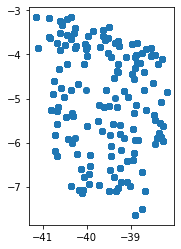

In [80]:
shapefile.plot()